In [1]:
import torch
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, ttest_rel, ttest_1samp, laplace, norm, lognorm, gaussian_kde
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import colorsys

plt.rcParams['font.family'] = 'Times New Roman'
letter_size=36

## Read in data

In [2]:
escape_date = '2025-02-14'
sb = .3

escape_results = torch.load(f'model_covdb/results.{escape_date}.sb{sb}.pt')
escape_traces = escape_results['traces']
escape_data = escape_results['data']

# escape_ranges = escape_traces['β_ω'].mean(dim=0).max(dim=0).values - escape_traces['β_ω'].mean(dim=0).min(dim=0).values

In [3]:
earliest_date = {  # PULLED FROM GISAID (seen 10 times)
    'Alpha': '2020-01-19' ,   # how is Alpha being seen before B.1 (widltype)...?
    'B.1': '2020-01-28' ,
    'BA.1': '2020-11-23' ,
    # 'BA.2': '2020-07-04' ,   # how is BA.2 being seen before BA.1...?
    # 'BA.5/7': '2020-07-21' ,
    'Beta': '2020-06-04' ,
    'Delta': '2020-05-01' ,
    # 'Epsilon': '2020-07-15' ,
    # 'Gamma': '2020-08-07' ,
    # 'Iota': '2020-12-02' ,
    # 'L452R': '2020-03-17' ,
    # 'Lambda': '2021-01-08' ,
    # 'Mu': '2021-02-21' ,
    'Omicron BA.4/5': '2020-07-04' ,
    'BA.2.12.1':''
    # 'WT': '2020-01-01', #None ,
    # 'pan-SARS-CoV-2': None ,
    # 'unknown': None
}

# Convert to DataFrame for sorting
earliest_date = pd.DataFrame(list(earliest_date.items()), columns=['Pool', 'First seen date'])
earliest_date['First seen date'] = pd.to_datetime(earliest_date['First seen date'])  
earliest_date = earliest_date.sort_values('First seen date')

# Create a color palette
colormap = dict(zip(earliest_date['Pool'], sns.color_palette("nipy_spectral", len(earliest_date))))
gray = (0.5, 0.5, 0.5)
# colormap['WT'] = gray
colormap['pan-SARS-CoV-2'] = gray
colormap['unknown'] = gray

# Create sort key
sortkey = earliest_date.sort_values(by='First seen date').reset_index(drop=True).reset_index()

In [4]:
pool_specific_effects = pd.DataFrame(columns=escape_data['features'], index=escape_data['pools_map'], data=escape_traces['β_ω'].mean(dim=0)
                                    ).reset_index(
                                    ).melt(id_vars='index', value_vars=None, var_name='Mutation', value_name='Effect'
                                    ).rename(columns={'index':'Pool'})
pool_agnostic_effects = pd.DataFrame({'Mutation':escape_data['features'], 'Effect':escape_traces['β'].mean(dim=0)})

# Subset ranges to where we have ample data on each mutation
min_n = 1  # mutation must have been seen at least once
subset = []
for _, row in pool_specific_effects.iterrows():
    pool_idx = (escape_data['pools_map']==row['Pool']).nonzero()[0][0]
    feat_idx = (np.array(escape_data['features'])==row['Mutation']).nonzero()[0][0]
    num_obs = escape_data['X'][escape_data['pools']==pool_idx, feat_idx].sum().item()
    row = dict(row)
    row['N'] = int(num_obs)
    if num_obs >= min_n:
        subset.append(row)
subset = pd.DataFrame(subset)

pool_specific_effects = pd.merge(pool_specific_effects, subset[['Mutation', 'Pool']], on=['Mutation', 'Pool'], how='inner')

In [5]:
# Get the difference in pool-specific effects for each mutation
mutation_effect_differences = pool_specific_effects[
                                      ['Mutation', 'Effect']
                                      ].groupby('Mutation'
                                      ).agg(lambda x: x.max() - x.min()
                                      ).reset_index(
                                      ).rename(columns={'Effect':'Effect difference'})

pool_effect_differences = pd.merge(pool_specific_effects.rename(columns={'Effect':'β_ω'}), 
                                   pool_agnostic_effects.rename(columns={'Effect':'β'}),
                                   on=['Mutation'])
pool_effect_differences['Effect difference'] = pool_effect_differences['β_ω'] - pool_effect_differences['β']
sorted_pool_effect_differences_df = pool_effect_differences.sort_values(by='Pool', key=lambda x: x.map({p:i for p, i in zip(sortkey['Pool'], sortkey['index'])}))

In [6]:
def get_positions(mutations):
    coefficients = mutations.copy()
    
    positions = [int(''.join(filter(str.isdigit, c))) for c in coefficients] #[int(c[1:-1]) for c in coefficients]
    return positions, coefficients

def get_region(position):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    for r, v in regions.items():
        if position >= v[0] and position <= v[1]:
            return r
    return 'Other'

pool_specific_effects['Position'], _ = get_positions(pool_specific_effects['Mutation'].tolist())
pool_specific_effects['Region'] = pool_specific_effects['Position'].apply(lambda x: get_region(x))

In [7]:
# # Calculate the avg pool specific effect
# pool_specific_effects = escape_traces['β_ω'].mean(dim=0)
# pool_agnostic_effects = escape_traces['β'].mean(dim=0)
# pool_effect_differences = pool_specific_effects - pool_agnostic_effects

# pool_effect_differences_df = pd.DataFrame(index=escape_data['pools_map'],
#                                           columns=escape_data['features'],
#                                           data=pool_effect_differences
#                                    ).reset_index(
#                                    ).melt(id_vars='index', 
#                                           var_name='Mutation', 
#                                           value_name='Effect difference'
#                                   ).rename(columns={'index':'Pool'})
# sorted_pool_effect_differences_df = pool_effect_differences_df.sort_values(by='Pool', key=lambda x: x.map({p:i for p, i in zip(sortkey['Pool'], sortkey['index'])}))


In [8]:
# Calculate moving average of relative pool escape
pool_effect_differences_df_withpos = sorted_pool_effect_differences_df
pool_effect_differences_df_withpos['Position'] = pool_effect_differences_df_withpos['Mutation'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
avg_pool_difference_by_pos = pool_effect_differences_df_withpos[['Pool', 'Position', 'Effect difference']
                                                      ].groupby(['Pool', 'Position']
                                                      ).agg('mean'
                                                      ).reset_index(
                                                      ).sort_values(by=['Position', 'Pool']
                                                      ).reset_index(drop=True);

window_size=100
avg_pool_difference_by_pos['Moving avg'] = avg_pool_difference_by_pos.groupby('Pool', group_keys=False, sort=False)['Effect difference'] \
                                                                      .apply(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

## Plot

In [9]:
# Manhattan plot
def setup(ax, ylim):
    options= dict()
    options['xlim'] = [0, 1273]
    options['ylim'] = ylim #[-1, 1]
    
    ax.set_xlim(options['xlim'])
    ax.set_ylim(options['ylim'])
    
    ax.set_ylabel('Mutation effect')
    ax.set_xlabel('Spike AA Position')

    return options

def get_positions(mutations):
    coefficients = mutations.copy()
    
    positions = [int(''.join(filter(str.isdigit, c))) for c in coefficients] #[int(c[1:-1]) for c in coefficients]
    return positions, coefficients

def plot_coef(ax, effects, positions, mutations, options):
    ax.plot(positions, effects, 'ro')
    
    texts = []
    for i, (pos, fea) in enumerate(zip(positions, mutations)):
        x = pos
        y = effects[i]
        text = fea #+ '\n' + '{:1.2f}'.format(y)
        texts.append(ax.annotate(text, xy=(x, y), xytext=(x, y), fontsize=8))

    # adjust_text(texts);
    
    ax.set_xlim(options['xlim'])
    
def plot_regions(ax, options):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    
    for r in regions:
        ax.vlines(regions[r], options['ylim'][0], options['ylim'][1], linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.fill_between(regions[r], options['ylim'][0], options['ylim'][1], color='tab:blue', alpha=0.1)
        ax.text(np.mean(regions[r]), options['ylim'][1]*0.95, r, ha='center', va='top', fontsize=7)

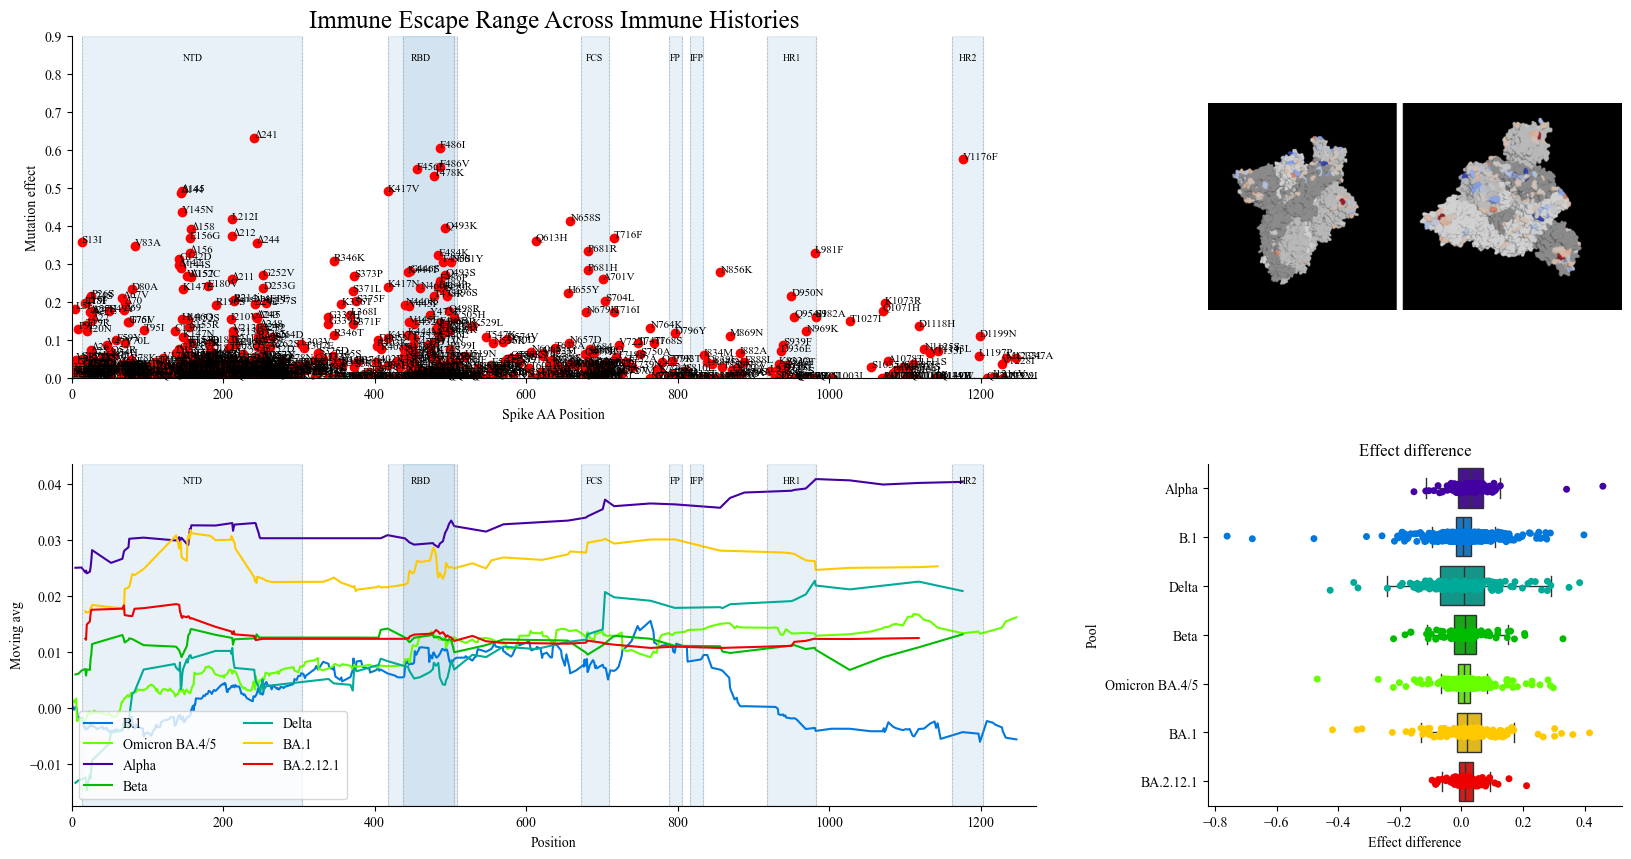

In [10]:
fig, axes = plt.subplots(2,2, figsize=(20,10), gridspec_kw={'width_ratios':[7,3]})

ax = axes[0,0]
options = setup(ax, [0, 0.9])
# positions, mutations = get_positions(escape_data['features'])
# plot_coef(ax, escape_ranges, positions, mutations, options)
positions, mutations = get_positions(mutation_effect_differences['Mutation'].tolist())
plot_coef(ax, mutation_effect_differences['Effect difference'].tolist(), positions, mutations, options)
plot_regions(ax, options)
ax.set_title('Immune Escape Range Across Immune Histories', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);

ax = axes[0,1]
img = mpimg.imread('figs/escape_struct_temp.png')
ax.imshow(img)
ax.axis('off');

ax = axes[1,0]
sns.lineplot(x='Position',
             y='Moving avg',
             hue='Pool',
             # fill=True,
             palette=colormap,
             data=avg_pool_difference_by_pos,
             ax=ax)
ax.set_xlim([0, 1273]);
ylim = ax.get_ylim()
plot_regions(ax, {'ylim':ylim})
ax.set_ylim(ylim)
ax.legend(loc='lower left', ncol=2)
ax.spines[['top', 'right']].set_visible(False);


ax = axes[1,1]
ax.set_title('Effect difference')
sns.boxplot(y='Pool',
            x='Effect difference',
            hue='Pool',
            palette=colormap,
            data=sorted_pool_effect_differences_df,
            showfliers=False,
            ax=ax)
sns.stripplot(y='Pool',
              x='Effect difference',
              hue='Pool',
              palette=colormap,
              data=sorted_pool_effect_differences_df,
              jitter=True,
              ax=ax);
ax.spines[['top', 'right']].set_visible(False);

# fig.tight_layout();
fig.subplots_adjust(hspace=0.25, wspace=0.25);
# fig.savefig(f'figs/covdb/Manhattan_{date}.png', dpi=150)

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_40464/1588600025.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([l if len(l.get_text())<10 else '' for l in ax.get_yticklabels()]);


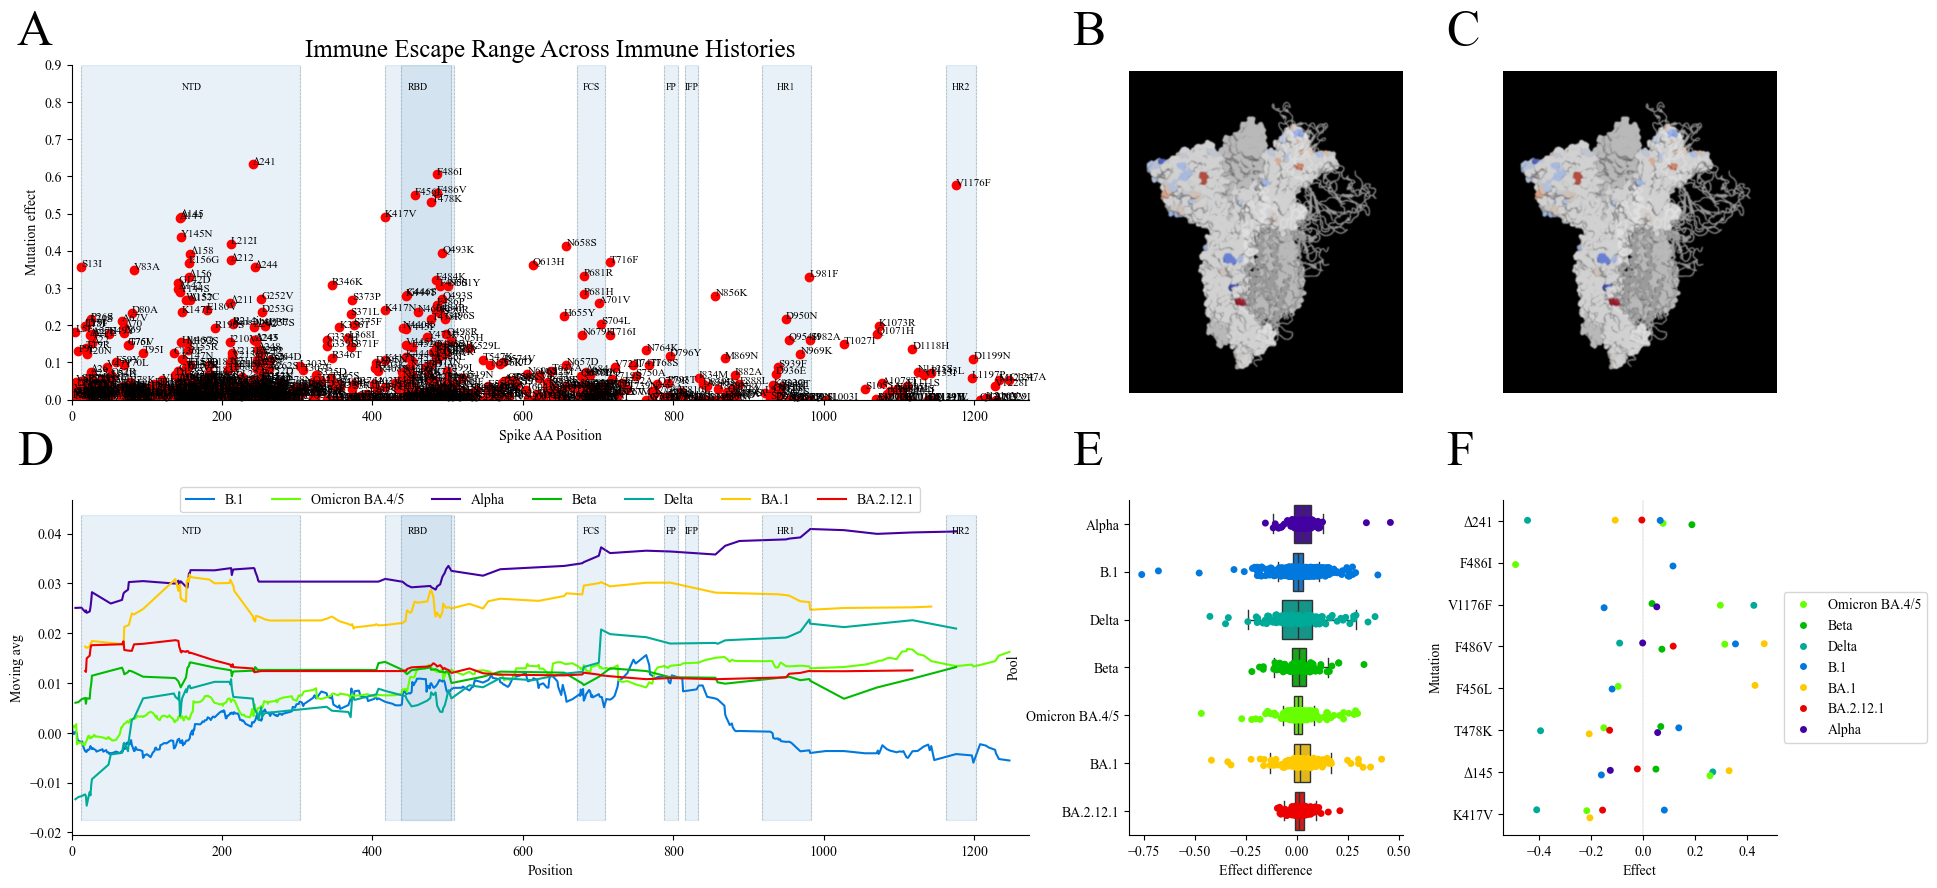

In [11]:
fig = plt.figure(figsize=(22,10))
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[7, 2, 2])

ax = fig.add_subplot(gs[0, 0])
fig.text(0.1, 0.9, 'A', fontsize=letter_size)
options = setup(ax, [0, 0.9])
positions, mutations = get_positions(mutation_effect_differences['Mutation'].tolist())
plot_coef(ax, mutation_effect_differences['Effect difference'].tolist(), positions, mutations, options)
plot_regions(ax, options)
ax.set_title('Immune Escape Range Across Immune Histories', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);


ax = fig.add_subplot(gs[0, 1])
fig.text(0.58, 0.9, 'B', fontsize=letter_size)
img = mpimg.imread('figs/infectivity_struct_temp.png')
ax.imshow(img)
ax.axis('off');


ax = fig.add_subplot(gs[0, 2])
fig.text(0.75, 0.9, 'C', fontsize=letter_size)
img = mpimg.imread('figs/infectivity_struct_temp.png')
ax.imshow(img)
ax.axis('off');


ax = fig.add_subplot(gs[1, 0])
fig.text(0.1, 0.48, 'D', fontsize=letter_size)
sns.lineplot(x='Position',
             y='Moving avg',
             hue='Pool',
             # fill=True,
             palette=colormap,
             data=avg_pool_difference_by_pos,
             ax=ax)
ax.set_xlim([0, 1273]);
plot_regions(ax, {'ylim':ax.get_ylim()})
ax.legend(loc='center', bbox_to_anchor=(0.5, 1), ncol=len(ax.get_legend_handles_labels()[0]))
ax.spines[['top', 'right']].set_visible(False);


ax = fig.add_subplot(gs[1, 1])
fig.text(0.58, 0.48, 'E', fontsize=letter_size)
sns.boxplot(y='Pool',
            x='Effect difference',
            hue='Pool',
            palette=colormap,
            data=sorted_pool_effect_differences_df,
            showfliers=False,
            ax=ax)
sns.stripplot(y='Pool',
              x='Effect difference',
              hue='Pool',
              palette=colormap,
              data=sorted_pool_effect_differences_df,
              jitter=True,
              ax=ax);
ax.spines[['top', 'right']].set_visible(False);


ax = fig.add_subplot(gs[1, 2])
fig.text(0.75, 0.48, 'F', fontsize=letter_size)
top_n = 8
sns.stripplot(x='Effect',
              y='Mutation',
              hue='Pool',
              palette=colormap,
              data=pd.merge(pool_specific_effects,
                            mutation_effect_differences.sort_values(by='Effect difference', ascending=False).head(top_n),
                            on='Mutation'
                           ).sort_values(by='Effect difference', ascending=False),
              ax=ax)
ax.spines[['top', 'right']].set_visible(False);
ylim = ax.get_ylim(); ax.vlines(0, ylim[0], ylim[1], color='gray', linewidth=0.25, linestyle='--'); ax.set_ylim(ylim);
ax.set_yticklabels([l if len(l.get_text())<10 else '' for l in ax.get_yticklabels()]);
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left');

fig.subplots_adjust(hspace=0.3);

#### Inspect top mutations

In [12]:
print(mutation_effect_differences[mutation_effect_differences['Mutation']=='Δ241'])
pool_specific_effects[pool_specific_effects['Mutation']=='Δ241'].sort_values(by='Effect')

    Mutation  Effect difference
745     Δ241           0.632103


Pool Mutation    Effect  Position Region
1844           Delta     Δ241 -0.444458       241    NTD
1841            BA.1     Δ241 -0.107334       241    NTD
1842       BA.2.12.1     Δ241 -0.004844       241    NTD
1840             B.1     Δ241  0.065699       241    NTD
1845  Omicron BA.4/5     Δ241  0.076576       241    NTD
1843            Beta     Δ241  0.187644       241    NTD

In [13]:
print(mutation_effect_differences[mutation_effect_differences['Mutation']=='F486I'])
pool_specific_effects[pool_specific_effects['Mutation']=='F486I'].sort_values(by='Effect')

    Mutation  Effect difference
135    F486I           0.605425


Pool Mutation    Effect  Position Region
318  Omicron BA.4/5    F486I -0.490506       486    RBD
317             B.1    F486I  0.114919       486    RBD

In [14]:
print(mutation_effect_differences[mutation_effect_differences['Mutation']=='V1176F'])
pool_specific_effects[pool_specific_effects['Mutation']=='V1176F'].sort_values(by='Effect')

    Mutation  Effect difference
637   V1176F            0.57579


Pool Mutation    Effect  Position Region
1573             B.1   V1176F -0.149985      1176    HR2
1574            Beta   V1176F  0.034350      1176    HR2
1572           Alpha   V1176F  0.052554      1176    HR2
1576  Omicron BA.4/5   V1176F  0.296920      1176    HR2
1575           Delta   V1176F  0.425805      1176    HR2

In [15]:
# fig = plt.figure(figsize=(20,13))
# gs = gridspec.GridSpec(4, 2, figure=fig, width_ratios=[7, 3], height_ratios=[3, 1, 0.5, 2])

# ax = fig.add_subplot(gs[0, 0])
# options = setup(ax, [0, 0.9])
# positions, mutations = get_positions(escape_data['features'])
# plot_coef(ax, escape_ranges, positions, mutations, options)
# plot_regions(ax, options)
# ax.set_title('Immune Escape Range Across Immune Histories', fontsize=18);
# ax.spines[['top', 'right']].set_visible(False);

# ax = fig.add_subplot(gs[0, 1])
# img = mpimg.imread('figs/escape_struct_temp.png')
# ax.imshow(img)
# ax.axis('off');

# ax = fig.add_subplot(gs[2:4, 0])
# sns.lineplot(x='Position',
#              y='Moving avg',
#              hue='Pool',
#              # fill=True,
#              palette=colormap,
#              data=avg_pool_difference_by_pos,
#              ax=ax)
# ax.set_xlim([0, 1273]);
# plot_regions(ax, {'ylim':ax.get_ylim()})
# ax.legend(loc='lower left')
# ax.spines[['top', 'right']].set_visible(False);

# ax = fig.add_subplot(gs[3, 1])
# sns.boxplot(y='Pool',
#             x='Effect difference',
#             hue='Pool',
#             palette=colormap,
#             data=sorted_pool_effect_differences_df,
#             showfliers=False,
#             ax=ax)
# sns.stripplot(y='Pool',
#               x='Effect difference',
#               hue='Pool',
#               palette=colormap,
#               data=sorted_pool_effect_differences_df,
#               jitter=True,
#               ax=ax);
# ax.spines[['top', 'right']].set_visible(False);
# xlim = ax.get_xlim()

# ax = fig.add_subplot(gs[2, 1])
# sns.kdeplot(x='Effect difference',
#             hue='Pool',
#             palette=colormap,
#             data=sorted_pool_effect_differences_df,
#             fill=True,
#             ax=ax);
# ax.set_xlim(xlim);
# ax.legend().set_visible(False);
# ax.axis('off');

# fig.subplots_adjust(hspace=0.05)

#### Do deletions in the NTD have a different effect than non-deletions?

In [16]:
ntd_mutation_effect_differences = mutation_effect_differences.copy()
ntd_mutation_effect_differences['Position'] = get_positions(ntd_mutation_effect_differences['Mutation'].tolist())[0]
ntd_mutation_effect_differences = ntd_mutation_effect_differences[ntd_mutation_effect_differences['Position'].apply(lambda x: x>=13 and x <=304)]
ntd_mutation_effect_differences['Deletion'] = ntd_mutation_effect_differences['Mutation'].apply(lambda x: x.startswith('Δ') or 'del' in x)
# T-test effect difference between deletions and non-deletions
s1 = ntd_mutation_effect_differences[ntd_mutation_effect_differences['Deletion']==True]['Effect difference'].tolist()
s2 = ntd_mutation_effect_differences[ntd_mutation_effect_differences['Deletion']==False]['Effect difference'].tolist()
res = ttest_ind(s1, s2)
print(f'P val: {res.pvalue}')
ntd_mutation_effect_differences[['Effect difference', 'Deletion']].groupby('Deletion').agg('mean')

P val: 4.2110117829106786e-09


Effect difference
Deletion                   
False              0.045264
True               0.122604

In [17]:
del_mutation_effect_differences = mutation_effect_differences.copy()
del_mutation_effect_differences['Position'] = get_positions(del_mutation_effect_differences['Mutation'].tolist())[0]
del_mutation_effect_differences = del_mutation_effect_differences[del_mutation_effect_differences['Mutation'].apply(lambda x: x.startswith('Δ') or 'del' in x)]
del_mutation_effect_differences['Region'] = del_mutation_effect_differences['Position'].apply(lambda x: 'NTD' if (x>=13 and x <=304) else 'Non-NTD')
# T-test effect difference between deletions and non-deletions
s1 = del_mutation_effect_differences[del_mutation_effect_differences['Region']=='NTD']['Effect difference'].tolist()
s2 = del_mutation_effect_differences[del_mutation_effect_differences['Region']!='NTD']['Effect difference'].tolist()
res = ttest_ind(s1, s2)
print(f'P val: {res.pvalue}')
del_mutation_effect_differences[['Effect difference', 'Region']].groupby('Region').agg('mean')

P val: 0.20606902468049218


Effect difference
Region                    
NTD               0.122604
Non-NTD           0.035190

In [18]:
non_ntd_mutation_effect_differences = mutation_effect_differences.copy()
non_ntd_mutation_effect_differences['Position'] = get_positions(non_ntd_mutation_effect_differences['Mutation'].tolist())[0]
non_ntd_mutation_effect_differences = non_ntd_mutation_effect_differences[~non_ntd_mutation_effect_differences['Position'].apply(lambda x: x>=13 and x <=304)]
non_ntd_mutation_effect_differences['Deletion'] = non_ntd_mutation_effect_differences['Mutation'].apply(lambda x: x.startswith('Δ') or 'del' in x)
# T-test effect difference between deletions and non-deletions
s1 = non_ntd_mutation_effect_differences[non_ntd_mutation_effect_differences['Deletion']==True]['Effect difference'].tolist()
s2 = non_ntd_mutation_effect_differences[non_ntd_mutation_effect_differences['Deletion']==False]['Effect difference'].tolist()
res = ttest_ind(s1, s2)
print(f'P val: {res.pvalue}')
non_ntd_mutation_effect_differences[['Effect difference', 'Deletion']].groupby('Deletion').agg('mean')

P val: 0.5522065691495166


Effect difference
Deletion                   
False              0.061846
True               0.035190

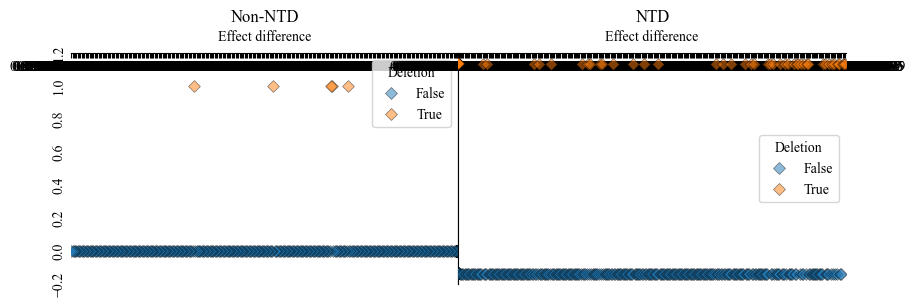

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0)
order=['Substitution', 'Deletion']

# NTD on the right
ax = axes[1]
ax.set_title('NTD')
data = ntd_mutation_effect_differences#[ntd_mutation_effect_differences['Region']=='NTD']
sns.stripplot(y='Deletion',
              x='Effect difference',
              hue='Deletion',
              data=data,
              jitter=True,
              alpha=0.5,
              marker='D',
              s=6,
              linewidth=0.5,
              edgecolor='k',
              ax=ax);
ax.spines[['right', 'bottom']].set_visible(False);
ax.set_yticks([]);

# Non-NTD on the left
ax = axes[0]
ax.set_title('Non-NTD')
data = non_ntd_mutation_effect_differences#[ntd_mutation_effect_differences['Region']!='NTD']
sns.stripplot(y='Deletion',
              x='Effect difference',
              hue='Deletion',
              data=data,
              jitter=True,
              alpha=0.5,
              marker='D',
              s=6,
              linewidth=0.5,
              edgecolor='k',
              ax=ax);
ax.set_xlim(reversed(ax.get_xlim()));
ax.spines[['left', 'bottom']].set_visible(False);
yticks=ax.get_yticks(); yticklabels = ax.get_yticklabels();
ax.set_yticks(yticks);
ax.tick_params(axis='y', length=0);
ax.set_yticklabels(yticklabels, rotation=90, va='center', ha='right');

for ax in axes:
    ax.set_ylabel('');
    ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, direction='in', pad=-15);
    ax.xaxis.set_label_coords(0.5, 1.1);

In [20]:
ntd_mutation_effect_differences

Mutation  Effect difference  Position  Deletion
3      A123S           0.031096       123     False
4      A163Y           0.041355       163     False
5      A222T           0.026251       222     False
6      A222V           0.000000       222     False
7      A243P           0.000000       243     False
..       ...                ...       ...       ...
774      Δ74           0.017386        74      True
775      Δ75           0.010906        75      True
776      Δ76           0.016602        76      True
777      Δ77           0.021269        77      True
778      Δ78           0.027351        78      True

[382 rows x 4 columns]

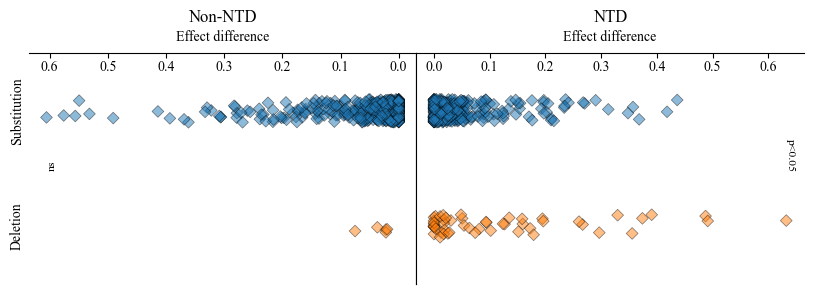

In [21]:
ntd_mutation_effect_differences = mutation_effect_differences.copy()
ntd_mutation_effect_differences['Position'] = get_positions(ntd_mutation_effect_differences['Mutation'].tolist())[0]
ntd_mutation_effect_differences['Deletion'] = ntd_mutation_effect_differences['Mutation'].apply(lambda x: 'Deletion' if (x.startswith('Δ') or 'del' in x) else 'Substitution')
ntd_mutation_effect_differences['Region'] = ntd_mutation_effect_differences['Position'].apply(lambda x: 'NTD' if (x>=13 and x <=304) else 'Non-NTD')


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0)
fs = 12

for i, (r, ax) in enumerate(zip(['Non-NTD', 'NTD'], axes)):
    ax.set_title(r)
    data = ntd_mutation_effect_differences[ntd_mutation_effect_differences['Region']==r]
    sns.stripplot(y='Deletion',
                  x='Effect difference',
                  hue='Deletion',
                  data=data,
                  jitter=True,
                  alpha=0.5,
                  marker='D',
                  s=6,
                  linewidth=0.5,
                  edgecolor='k',
                  ax=ax);
    
    # Significance test
    s1 = data[data['Deletion']=='Deletion']['Effect difference'].tolist()
    s2 = data[data['Deletion']=='Substitution']['Effect difference'].tolist()
    res = ttest_ind(s1, s2)
    if res.pvalue < 0.05:
        ax.text(data['Effect difference'].max(), 0.5, 'p<0.05', rotation=270, fontsize=fs*0.7)
    else:
        ax.text(data['Effect difference'].max(), 0.5, 'ns', rotation=90, fontsize=fs*0.7)

    
    if i == 0:
        spines = ['left', 'bottom']
        yticks = ax.get_yticks()
        yticklabels = ax.get_yticklabels()
        xlim = reversed(ax.get_xlim())
    else:
        spines = ['right', 'bottom']
        yticks = []
        yticklabels = []
        xlim = ax.get_xlim()
        
    ax.spines[spines].set_visible(False);
    ax.set_yticks(yticks);
    ax.set_yticklabels(yticklabels, rotation=90, va='center', ha='right');
    ax.tick_params(axis='y', length=0);
    ax.set_xlim(xlim);
    ax.set_ylabel('');
    ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, direction='in', pad=-15);
    ax.xaxis.set_label_coords(0.5, 1.1);

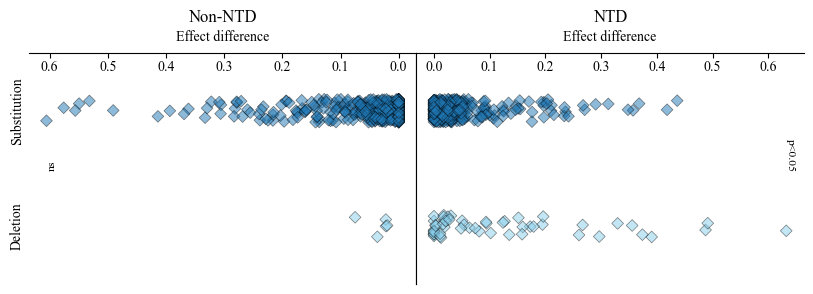

In [22]:
ntd_mutation_effect_differences = mutation_effect_differences.copy()
ntd_mutation_effect_differences['Position'] = get_positions(ntd_mutation_effect_differences['Mutation'].tolist())[0]
ntd_mutation_effect_differences['Deletion'] = ntd_mutation_effect_differences['Mutation'].apply(lambda x: 'Deletion' if (x.startswith('Δ') or 'del' in x) else 'Substitution')
ntd_mutation_effect_differences['Region'] = ntd_mutation_effect_differences['Position'].apply(lambda x: 'NTD' if (x>=13 and x <=304) else 'Non-NTD')

palette={'Substitution':'tab:blue', 'Deletion':'skyblue'}

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0)
fs = 12

for i, (r, ax) in enumerate(zip(['Non-NTD', 'NTD'], axes)):
    ax.set_title(r)
    data = ntd_mutation_effect_differences[ntd_mutation_effect_differences['Region']==r]
    sns.stripplot(y='Deletion',
                  x='Effect difference',
                  hue='Deletion',
                  data=data,
                  jitter=True,
                  alpha=0.5,
                  marker='D',
                  palette=palette,
                  s=6,
                  linewidth=0.5,
                  edgecolor='k',
                  ax=ax);
    
    # Significance test
    s1 = data[data['Deletion']=='Deletion']['Effect difference'].tolist()
    s2 = data[data['Deletion']=='Substitution']['Effect difference'].tolist()
    res = ttest_ind(s1, s2)
    if res.pvalue < 0.05:
        ax.text(data['Effect difference'].max(), 0.5, 'p<0.05', rotation=270, fontsize=fs*0.7)
    else:
        ax.text(data['Effect difference'].max(), 0.5, 'ns', rotation=90, fontsize=fs*0.7)

    
    if i == 0:
        spines = ['left', 'bottom']
        yticks = ax.get_yticks()
        yticklabels = ax.get_yticklabels()
        xlim = reversed(ax.get_xlim())
    else:
        spines = ['right', 'bottom']
        yticks = []
        yticklabels = []
        xlim = ax.get_xlim()
        
    ax.spines[spines].set_visible(False);
    ax.set_yticks(yticks);
    ax.set_yticklabels(yticklabels, rotation=90, va='center', ha='right');
    ax.tick_params(axis='y', length=0);
    ax.set_xlim(xlim);
    ax.set_ylabel('');
    ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, direction='in', pad=-15);
    ax.xaxis.set_label_coords(0.5, 1.1);

## Alternate Figure 2
Need the following elements:
1. Prior dist on beta
2. Prior dist on sigma
3. Beta_i trace
4. Sigma_i trace
5. Laplace trace, Laplace avg
6. Pool traces with means annotated
7. Pool distributions

In [23]:
def laplace(x, μ, b):
    return 1/(2*b) * np.exp(-np.abs(x - μ)/b)

def normal(x, μ, σ):
    kern = (x - μ)**2 / (2*σ**2)
    return 1 / np.sqrt(2*np.pi*σ**2) * np.exp(-kern)

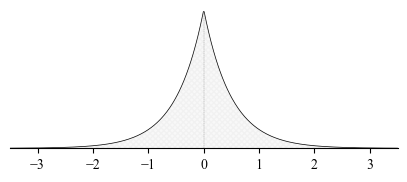

In [24]:
# Prior dist on beta
fig, ax = plt.subplots(figsize=(5, 1.8))
fs = 12
xlim = [-3.5, 3.5]
ylim = [0, 1]

x = np.linspace(xlim[0], xlim[1], 500)
μ = 0; b = 0.5
y = laplace(x, μ, b) #laplace(μ, b).pdf(x)
ax.plot(x, y, color='k', linewidth=0.5)
ax.fill_between(x, y, color='gray', alpha=0.05, hatch='xxxxxx')
ax.vlines(μ, 0, np.max(y), color='gray', linewidth=0.25, linestyle='--')

ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_yticks([]); ax.set_xlabel('');
ax.spines[['top', 'right', 'left']].set_visible(False);

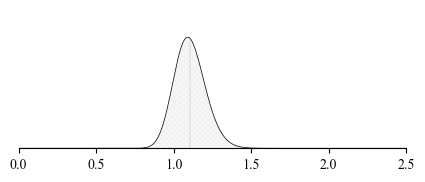

In [25]:
# Prior dist on sigma
fig, ax = plt.subplots(figsize=(5, 1.8))
fs = 12
xlim = [0, 2.5]
ylim = [0, 5]

x = np.linspace(xlim[0], xlim[1], 500)
μ = 0.1; b = 0.1
y = lognorm(μ, b).pdf(x)
ax.plot(x, y, color='k', linewidth=0.5)
ax.fill_between(x, y, color='gray', alpha=0.05, hatch='xxxxxx')
ax.vlines(np.exp(μ), 0, np.max(y), color='gray', linewidth=0.25, linestyle='--')

ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_yticks([]); ax.set_xlabel('');
ax.spines[['top', 'right', 'left']].set_visible(False);

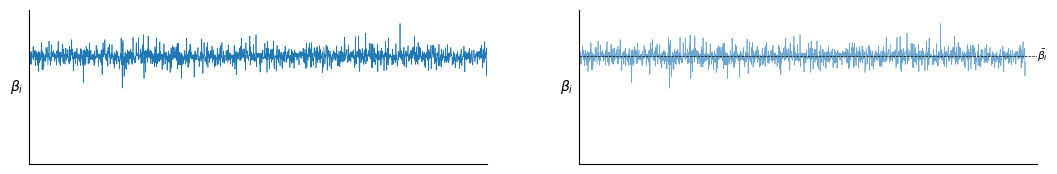

In [26]:
# Beta_i trace
tracelen = 2000
fig, axes = plt.subplots(1, 2, figsize=(13, 2))
fs = 12
ylim = [-3, 3]
βi = 1.2
b = 0.15
trace1 = np.random.laplace(βi, b, tracelen)

ax = axes[0]
# mean = 0.6; var = 0.5; trace1 = [(i-0.5)*var+mean for i in trace1];
ax.plot(trace1, linewidth=0.5);
ax.set_ylim(ylim); ax.set_xlim([0, tracelen]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\beta_i$', rotation=0, ha='right', va='center');

ax = axes[1]
overhang = 1.025
# mean = 0.6; var = 0.5; trace1 = [(i-0.5)*var+mean for i in trace1];
ax.plot(trace1, linewidth=0.5, alpha=0.65);
ax.hlines(βi, 0, tracelen*overhang, linestyle='--', color='k', linewidth=0.5);
ax.text(tracelen*overhang, βi, r'$\bar{\beta_{i}}$', ha='left', va='center', fontsize=0.65*fs);
ax.set_ylim(ylim); ax.set_xlim([0, tracelen*overhang]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\beta_i$', rotation=0, ha='right', va='center');

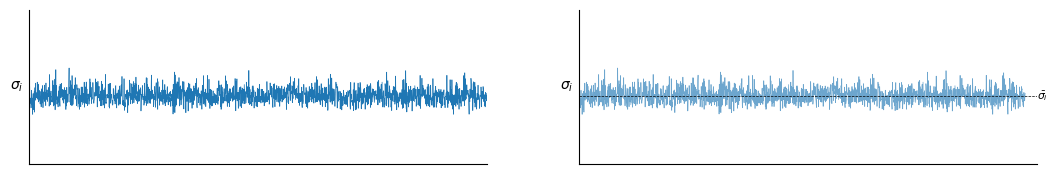

In [27]:
# Beta_i trace
fig, axes = plt.subplots(1, 2, figsize=(13, 2))
fs = 12
ylim = [0, 2.5]
σi = np.exp(0.1)
trace2 = np.random.lognormal(np.log(σi), 0.1, tracelen)


ax = axes[0]
# mean = 0.6; var = 0.5; trace1 = [(i-0.5)*var+mean for i in trace1];
ax.plot(trace2, linewidth=0.5);
ax.set_ylim(ylim); ax.set_xlim([0, tracelen]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\sigma_i$', rotation=0, ha='right', va='center');

ax = axes[1]
overhang = 1.025
# mean = 0.6; var = 0.5; trace1 = [(i-0.5)*var+mean for i in trace1];
ax.plot(trace2, linewidth=0.5, alpha=0.65);
ax.hlines(σi, 0, tracelen*overhang, linestyle='--', color='k', linewidth=0.5);
ax.text(tracelen*overhang, σi, r'$\bar{\sigma_{i}}$', ha='left', va='center', fontsize=0.65*fs);
ax.set_ylim(ylim); ax.set_xlim([0, tracelen*overhang]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\sigma_i$', rotation=0, ha='right', va='center');

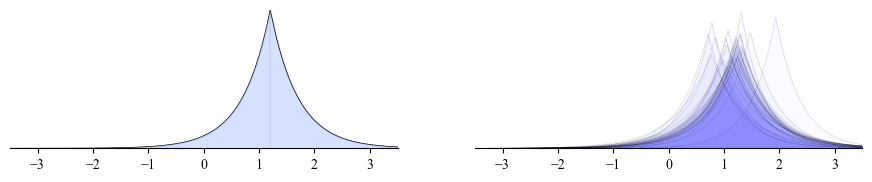

In [28]:
# Laplace trace, Laplace avg
fig, axes = plt.subplots(1, 2, figsize=(11, 1.8))

ax = axes[0]
fs = 12
xlim = [-3.5, 3.5]
ylim = [0, 1]
βj = 1.2; b = 0.5;
x = np.linspace(xlim[0], xlim[1], 500);
yj = laplace(x, βj, b)#laplace(βj, b).pdf(x)
ax.plot(x, yj, color='k', linewidth=0.5)
ax.fill_between(x, yj, color=(0.2, 0.4, 1), alpha=0.2)
ax.vlines(βj, 0, np.max(yj), color='gray', linewidth=0.25, linestyle='--')
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_yticks([]); ax.set_xlabel('');
ax.spines[['top', 'right', 'left']].set_visible(False);


ax = axes[1]
fs = 12
xlim = [-3.5, 3.5]
ylim = [0, 1.2]
x = np.linspace(xlim[0], xlim[1], 500)
step = 75
for u, s in zip(trace1[::step], trace2[::step]):
    y = laplace(x, u, s/2)#laplace(u, s/2).pdf(x)
    ax.plot(x, y, marker='', linewidth=0.2, color='k', alpha=0.3)
    ax.fill_between(x, y, 0, color='blue', alpha=0.02);
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_yticks([]); ax.set_xlabel('');
ax.spines[['top', 'right', 'left']].set_visible(False);

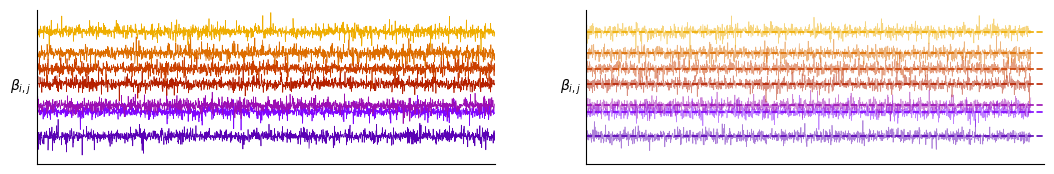

In [29]:
# Pool traces with means annotated
fig, axes = plt.subplots(1, 2, figsize=(13, 2))
βji = [-0.6, 0.2, 0.4, 1.1, 1.6, 2.1, 2.8]
varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}
b=0.5
ylim = [-1.5, 3.5]

ax = axes[0]
for i, v in enumerate(varns):
    # trace = np.random.random(tracelen)
    # mean = βji[i]; var = b; trace = [(t-0.5)*var+mean for t in trace];
    mean = βji[i]; var = 0.15*b; trace = np.random.laplace(mean, var, tracelen);
    ax.plot(trace, linewidth=0.5, color=pool_colors[v]);
ax.set_ylim([-1.5, 3.5]); ax.set_xlim([0, tracelen]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\beta_{i,j}$', rotation=0, ha='right', va='center');


overhang = 1.03
ax = axes[1]
for i, v in enumerate(varns):
    # trace = np.random.random(tracelen)
    # mean = βji[i]; var = b; trace = [(t-0.5)*var+mean for t in trace];
    mean = βji[i]; var = 0.15*b; trace = np.random.laplace(mean, var, tracelen);
    ax.plot(trace, linewidth=0.5, color=pool_colors[v], alpha=0.5);
    ax.hlines(mean, 0, tracelen*overhang, color=pool_colors[v], linewidth=1.2, linestyle='--')
ax.set_ylim(ylim); ax.set_xlim([0, tracelen*overhang]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\beta_{i,j}$', rotation=0, ha='right', va='center');

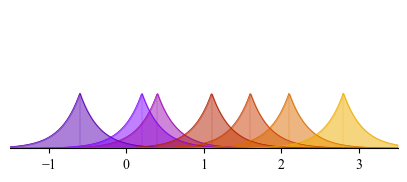

In [30]:
# Pool distributions
fig, ax = plt.subplots(figsize=(5, 1.8))
fs = 12
xlim = [-1.5, 3.5]
ylim = [0, 1]
b=0.5
x = np.linspace(xlim[0], xlim[1], 500)
for i, v in enumerate(varns):
    yji = laplace(x, βji[i], b/2)/5#laplace(βji[i], b/2).pdf(x)/5
    ax.plot(x, yji, color=pool_colors[v], linewidth=0.5)
    ax.fill_between(x, yji, color=pool_colors[v], alpha=0.5)
    ax.vlines(βji[i], 0, np.max(yji), color=pool_colors[v], linewidth=0.25, linestyle='--')
    
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_yticks([]); ax.set_xlabel('');
ax.spines[['top', 'right', 'left']].set_visible(False);

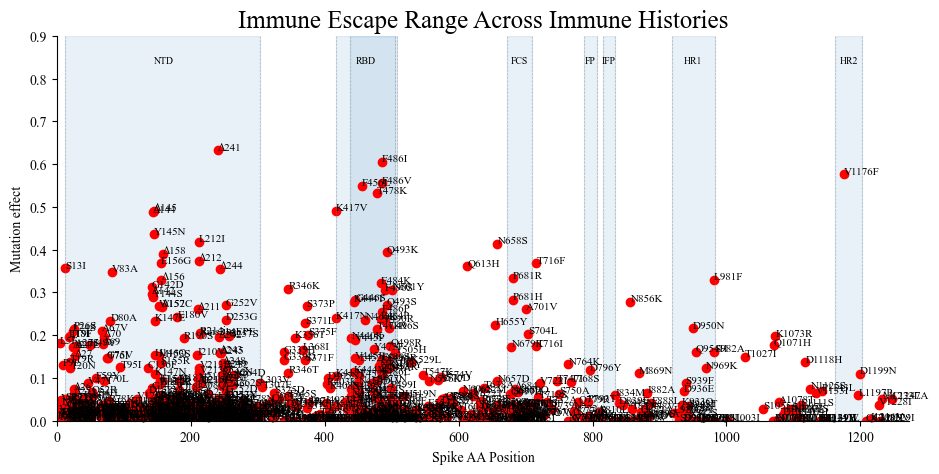

In [31]:
def plot_coef(ax, effects, positions, mutations, options):
    ax.plot(positions, effects, 'ro')
    
    texts = []
    for i, (pos, fea) in enumerate(zip(positions, mutations)):
        x = pos
        y = effects[i]
        text = fea #+ '\n' + '{:1.2f}'.format(y)
        texts.append(ax.annotate(text, xy=(x, y), xytext=(x, y), fontsize=8))
        
        # if i>50:
        #     break
    
    ax.set_xlim(options['xlim'])

fig, ax = plt.subplots(figsize=(11, 5))
options = setup(ax, [0, 0.9])
positions, mutations = get_positions(mutation_effect_differences.sort_values(by='Effect difference', ascending=False)['Mutation'].tolist())
plot_coef(ax, mutation_effect_differences.sort_values(by='Effect difference', ascending=False)['Effect difference'].tolist(), positions, mutations, options)
plot_regions(ax, options)
ax.set_title('Immune Escape Range Across Immune Histories', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);

/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 77.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 22.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 39.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/k

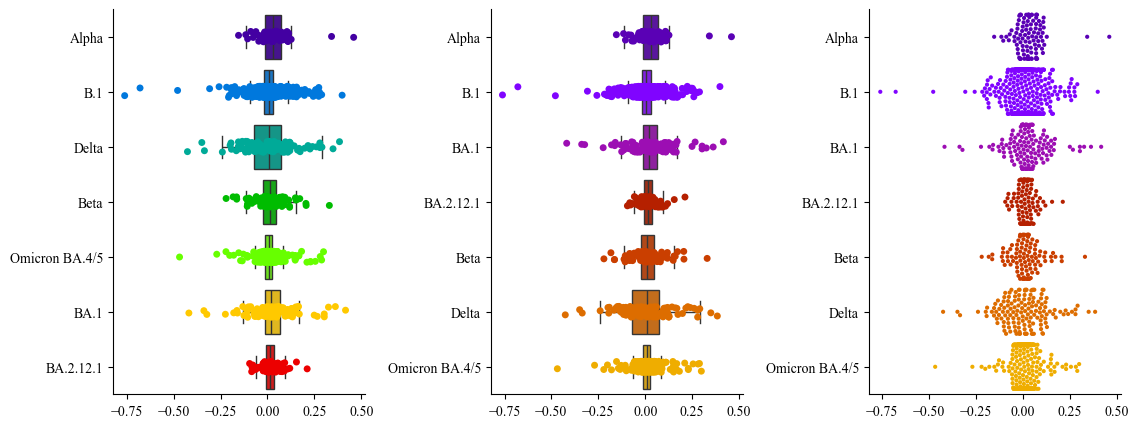

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
fig.subplots_adjust(wspace=0.5);

ax = axes[0]
sns.boxplot(y='Pool',
            x='Effect difference',
            hue='Pool',
            palette=colormap,
            data=sorted_pool_effect_differences_df,
            showfliers=False,
            ax=ax)
sns.stripplot(y='Pool',
              x='Effect difference',
              hue='Pool',
              palette=colormap,
              data=sorted_pool_effect_differences_df,
              jitter=True,
              ax=ax);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(''); ax.set_xlabel('');

ax = axes[1]
varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}
sns.boxplot(y='Pool',
            x='Effect difference',
            hue='Pool',
            palette=pool_colors,
            data=sorted_pool_effect_differences_df,
            order=varns,
            showfliers=False,
            ax=ax)
sns.stripplot(y='Pool',
              x='Effect difference',
              hue='Pool',
              palette=pool_colors,
              data=sorted_pool_effect_differences_df,
              jitter=True,
              order=varns,
              ax=ax);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(''); ax.set_xlabel('');

ax = axes[2]
sns.swarmplot(y='Pool',
              x='Effect difference',
              hue='Pool',
              palette=pool_colors,
              data=sorted_pool_effect_differences_df,
              # jitter=True,
              order=varns,
              s=3,
              ax=ax);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(''); ax.set_xlabel('');

In [33]:
for v in varns:
    subset = sorted_pool_effect_differences_df[sorted_pool_effect_differences_df['Pool']==v]
    dist = subset['Effect difference'].tolist()
    res = ttest_1samp(dist, popmean=0)
    print('Pool: ', v)
    print(f'Population mean: {np.mean(dist):.4f}')
    print(f'!=0 pvalue: {res.pvalue:.4f}')
    print('Significant? ', res.pvalue < 0.05)
    print()

Pool:  Alpha
Population mean: 0.0326
!=0 pvalue: 0.0000
Significant?  True

Pool:  B.1
Population mean: 0.0077
!=0 pvalue: 0.0058
Significant?  True

Pool:  BA.1
Population mean: 0.0232
!=0 pvalue: 0.0173
Significant?  True

Pool:  BA.2.12.1
Population mean: 0.0152
!=0 pvalue: 0.0006
Significant?  True

Pool:  Beta
Population mean: 0.0127
!=0 pvalue: 0.1215
Significant?  False

Pool:  Delta
Population mean: 0.0049
!=0 pvalue: 0.6289
Significant?  False

Pool:  Omicron BA.4/5
Population mean: 0.0085
!=0 pvalue: 0.0001
Significant?  True



/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_40464/1168966952.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([l if len(l.get_text())<10 else '' for l in ax.get_yticklabels()]);


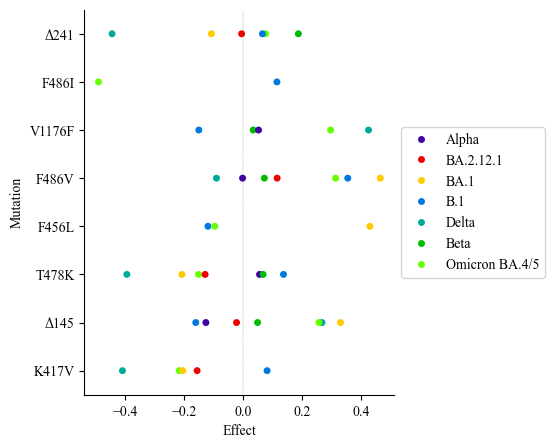

In [34]:
fig, ax = plt.subplots(figsize=(4, 5))
top_n = 8
sns.stripplot(x='Effect',
              y='Mutation',
              hue='Pool',
              palette=colormap,
              jitter=False,
              data=pd.merge(pool_specific_effects,
                            mutation_effect_differences.sort_values(by='Effect difference', ascending=False).head(top_n),
                            on='Mutation'
                           ).sort_values(by='Effect difference', ascending=False),
              ax=ax)
ax.spines[['top', 'right']].set_visible(False);
ylim = ax.get_ylim(); ax.vlines(0, ylim[0], ylim[1], color='gray', linewidth=0.25, linestyle='--'); ax.set_ylim(ylim);
ax.set_yticklabels([l if len(l.get_text())<10 else '' for l in ax.get_yticklabels()]);
# Reverse the legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.5), loc='center left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

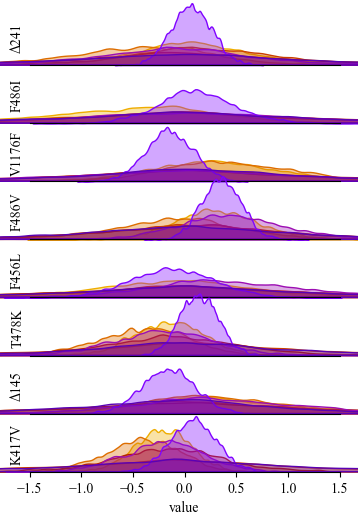

In [35]:
top_n = 8
top_n_muts = mutation_effect_differences.sort_values(by='Effect difference', ascending=False).head(top_n)['Mutation'].tolist()
top_n_muts_idxs = [escape_data['features'].index(m) for m in top_n_muts]
top_n_muts_traces = escape_traces['β_ω'][:, :, np.array(top_n_muts_idxs)]

fig, axes = plt.subplots(top_n, 1, figsize=(4, 0.75*top_n))
fig.subplots_adjust(hspace=0.05);

varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

for i in range(top_n):
    ax = axes[i]
    df_temp = pd.DataFrame(columns=escape_data['pools_map'], data=top_n_muts_traces[:, :, i]).melt(value_vars=escape_data['pools_map'], var_name=['Pool'])
    sns.kdeplot(x='value',
                hue='Pool',
                fill=True,
                alpha=0.35,
                bw_adjust=0.35,
                palette=pool_colors,
                data=df_temp,
                clip_on=False,
                ax=ax);
    ax.legend().set_visible(False);
    ax.set_xlim([-1.5, 1.5]);
    ax.set_ylim([0, 0.27]);
    ax.set_yticks([]); ax.set_ylabel(top_n_muts[i]);
    ax.spines[['left', 'right', 'top']].set_visible(False);
    if i<top_n-1:
        ax.set_xticks([]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

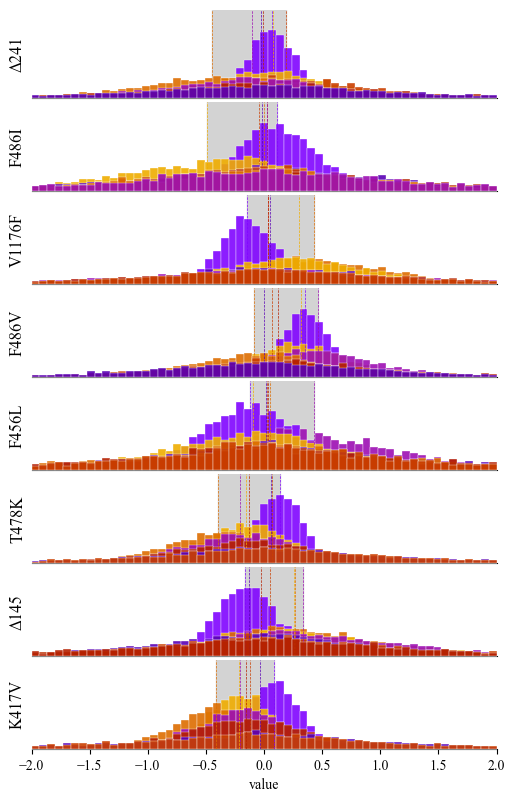

In [36]:
top_n = 8
top_n_muts = mutation_effect_differences.sort_values(by='Effect difference', ascending=False).head(top_n)['Mutation'].tolist()
top_n_muts_idxs = [escape_data['features'].index(m) for m in top_n_muts]
top_n_muts_traces = escape_traces['β_ω'][:, :, np.array(top_n_muts_idxs)]
top_n_muts_traces.shape

fig, axes = plt.subplots(top_n, 1, figsize=(6, 1.2*top_n))
fig.subplots_adjust(hspace=0.05);
fs = 12

varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

xlim = [-2, 2]
bins = np.linspace(xlim[0], xlim[1], 60)
for i in range(top_n):
    ax = axes[i]
    df_temp = pd.DataFrame(columns=escape_data['pools_map'], data=top_n_muts_traces[:, :, i]).melt(value_vars=escape_data['pools_map'], var_name=['Pool'])
    
    peak_heights = (df_temp
                    .groupby('Pool')['value']
                    .apply(lambda x: np.histogram(x, bins=bins)[0].max())
                    )
    hue_order = peak_heights.sort_values(ascending=False).index.tolist()
    
    # sns.histplot(x='value',
    #             hue='Pool',
    #             bins=bins,
    #             linewidth=0.25,
    #             edgecolor='white',
    #             alpha=0.9,
    #             palette=pool_colors,
    #             data=df_temp[df_temp['value'].apply(lambda x: x>xlim[0] and x<xlim[1])],
    #             hue_order=reversed(hue_order),
    #             clip_on=False,
    #             ax=ax);
    
    # Now, annotate effect range
    effect_min = df_temp.groupby('Pool').agg('mean').min().value
    effect_max = df_temp.groupby('Pool').agg('mean').max().value
    ylim = [0, peak_heights.max()*1.3]
    ax.fill_between([effect_min, effect_max], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='lightgray', zorder=-1)
    for z, pool in enumerate(hue_order):
        sns.histplot(x='value',
            hue='Pool',
            bins=bins,
            linewidth=0.25,
            edgecolor='white',
            alpha=0.9,
            palette=pool_colors,
            data=df_temp[(df_temp['value'].apply(lambda x: x>xlim[0] and x<xlim[1])) & (df_temp['Pool']==pool)],
            zorder=z,
            clip_on=False,
            ax=ax);
        ax.vlines(df_temp[df_temp['Pool']==pool]['value'].mean(), ylim[0], ylim[1], color=pool_colors[pool], linestyle='--', linewidth=0.5, zorder=i)
    ax.set_ylim(ylim);
    
    ax.legend().set_visible(False);
    ax.set_xlim(xlim);
    # ax.set_ylim([0, 0.27]);
    ax.set_yticks([]); ax.set_ylabel(top_n_muts[i], fontsize=fs);
    ax.spines[['left', 'right', 'top']].set_visible(False);
    if i<top_n-1:
        ax.set_xticks([]);

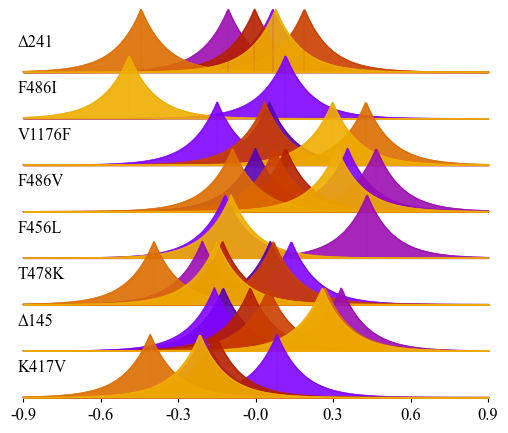

In [37]:
top_n = 8
fig, axes = plt.subplots(top_n, 1, figsize=(6, 0.6*(top_n)))
fig.subplots_adjust(hspace=0.05);

varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

xlim = [-0.9, 0.9];
ylim = [0, 3.5]
x = np.linspace(xlim[0], xlim[1], 500)
b = 0.1
for i, row in mutation_effect_differences.sort_values(by='Effect difference', ascending=False).head(top_n).reset_index(drop=True).iterrows():
    ax = axes[i]
    
    data_mut = pool_specific_effects[pool_specific_effects['Mutation']==row['Mutation']].reset_index(drop=True)
    for j, row in data_mut.iterrows():
        yji = laplace(x, row['Effect'], b)
        ax.plot(x, yji, color=pool_colors[row['Pool']], linewidth=0.5, clip_on=False, zorder=i)
        ax.fill_between(x, yji, color=pool_colors[row['Pool']], alpha=0.9, clip_on=False, zorder=i)
        ax.vlines(row['Effect'], 0, np.max(yji), color=pool_colors[row['Pool']], linewidth=0.25, linestyle='--', clip_on=False)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([]); ax.set_yticks([]);
    ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False);
    ax.set_ylabel(row['Mutation'], rotation=0, ha='left', fontsize=fs)
    
    if i==top_n-1:
        ax.spines[['bottom']].set_visible(True)
        xticks = np.linspace(xlim[0], xlim[1], 7)
        ax.set_xticks(xticks);
        ax.set_xticklabels([f'{tick:.1f}' for tick in xticks], fontsize=fs)
        

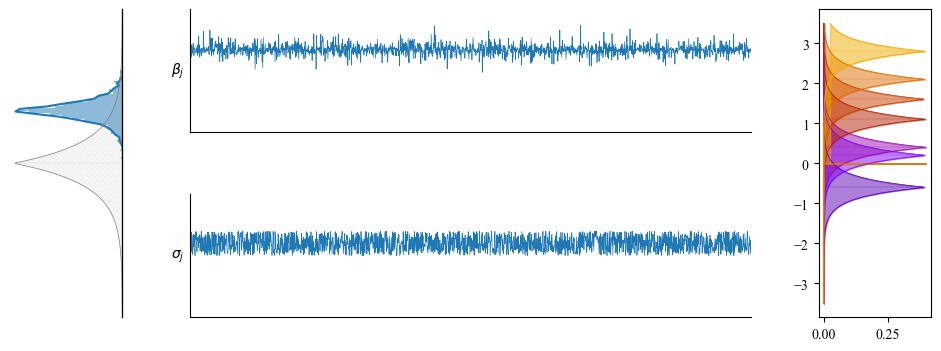

In [38]:
###################################################################################
##### ROW 1: PRIORS
###################################################################################
fig = plt.figure(figsize=(20, 4))
gs = gridspec.GridSpec(2, 4, figure=fig, width_ratios=[1, 5, 1, 5])
fig.subplots_adjust(hspace=0.5);ms = 8
fs = 12
ylim = [-3.5, 3.5]
xlim = [1, 0]
b = 0.2
tracelen = 2000

# # Immune-Agnostic Effect Dist
# ax = fig.add_subplot(gs[:, 0])
# y = np.linspace(ylim[0], ylim[1], 500)
# xj = laplace(y, βj, b)
# ax.plot(xj, y, color='k', linewidth=0.5)
# ax.fill_between(xj, y, color=(0.2, 0.4, 1), alpha=0.2)
# ax.hlines(βj, 0, np.max(xj), color='gray', linewidth=0.25, linestyle='--')
# ax.set_xlim(xlim);
# ax.set_xticks([]); ax.set_yticks([]);
# ax.spines[['top', 'bottom', 'left']].set_visible(False);

# Immune-Agnostic Effect Traces
ax = fig.add_subplot(gs[0, 1])
trace1 = np.random.laplace(βj, b, tracelen)
# mean = 0.6; var = 0.5; trace1 = [(i-0.5)*var+mean for i in trace1];
ax.plot(trace1, linewidth=0.5);
ax.set_ylim(ylim); ax.set_xlim([0, tracelen]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\beta_j$', rotation=0, ha='right', va='center');

ax = fig.add_subplot(gs[1, 1])
trace2 = np.random.random(tracelen)
mean = 0.6; var = 0.2; trace2 = [(i-0.5)*var+mean for i in trace2];
ax.plot(trace2, linewidth=0.5);
ax.set_ylim([0, 1]); ax.set_xlim([0, tracelen]);
ax.set_xticks([]); ax.set_yticks([]);
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylabel(r'$\sigma_j$', rotation=0, ha='right', va='center');

# Immune-Agnostic Effect Dist
ax = fig.add_subplot(gs[:, 0])
sns.histplot(y=trace1,
             alpha=0.5,
             edgecolor='none',
             ax=ax);
ax2 = ax.twiny()
sns.kdeplot(y=trace1,
            color='tab:blue',
            bw_adjust=0.5,
            gridsize=50,
            # fill=True,
            # alpha=0.5,
            ax=ax2);

# Prior
y = np.linspace(ylim[0], ylim[1], 500)
μ = 0; b = 0.5
x = laplace(y, μ, b)
ax3 = ax.twiny()
ax3.plot(x, y, color='gray', linewidth=0.5)
ax3.fill_between(x, y, color='gray', alpha=0.05, hatch='xxxxxx')


for ax in [ax, ax2, ax3]:
    ax.set_xlim([ax.get_xlim()[1], ax.get_xlim()[0]+0.05]); ax.set_ylim(ylim);
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel('');
    ax.spines[['top', 'bottom', 'left']].set_visible(False);


# Immune-Specific Effect Dists
###### POOL-SPECIFIC
ax = fig.add_subplot(gs[:, 2]) 
βji = [-0.6, 0.2, 0.4, 1.1, 1.6, 2.1, 2.8]
varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}
for i, v in enumerate(varns):
    xji = laplace(y, βji[i], b/2)/5
    ax.plot(xji, y, color=pool_colors[v], linewidth=0.5)
    ax.fill_between(xji, y, color=pool_colors[v], alpha=0.5)
    ax.hlines(βji[i], 0, np.max(xji), color=pool_colors[v], linewidth=0.25, linestyle='--')

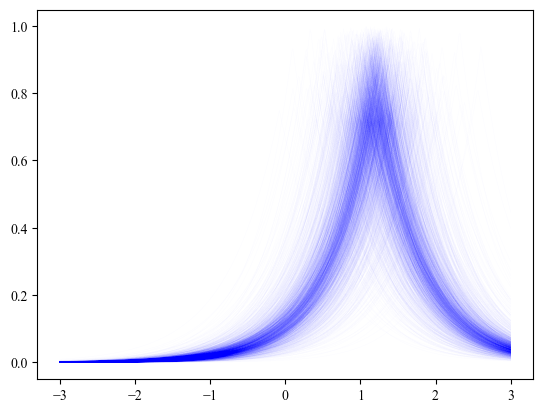

In [39]:
fig, ax = plt.subplots()
for u, s in zip(trace1, trace2):
    x = np.linspace(-3, 3, 500)
    y = laplace(x, u, s)
    ax.plot(x, y, marker='', linewidth=0.5, color='blue', alpha=0.01)
    # ax.fill_between(x, y, 0, alpha=0.01, color='tab:blue');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


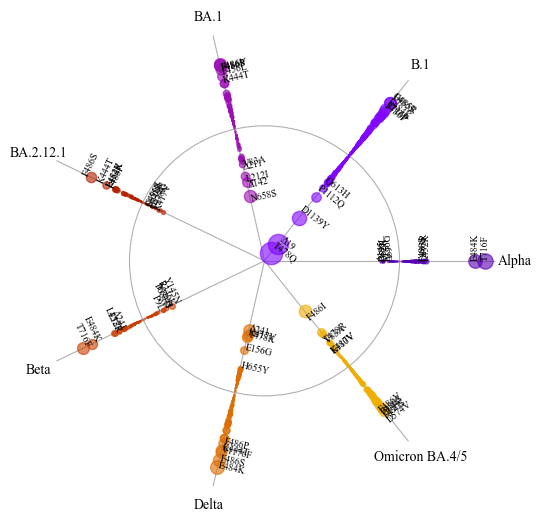

In [40]:
pools = pool_colors.keys()
angles = np.linspace(0, 2 * np.pi, len(pools), endpoint=False).tolist()
fs=7
ms=16

pool_specific_effects_polar = pool_specific_effects
pool_specific_effects_polar['Angle'] = pool_specific_effects['Pool'].apply(lambda x: dict({p:a for p, a in zip(pools, angles)})[x])

max_effect = np.abs(pool_specific_effects['Effect']).max()
# max_effect_by_pool = {pool:effect.values for pool, effect in pool_specific_effects[['Pool', 'Effect']].groupby('Pool').agg(lambda x: np.abs(x).max()).iterrows()}

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw points
for _, row in pool_specific_effects_polar.iterrows():
    ax.plot(row['Angle'], row['Effect'], 
            marker='o', color=pool_colors[row['Pool']], alpha=0.6, 
            markersize=np.abs(row['Effect'])*ms/max_effect)
# Label top / bottom n
n = 5
def handle_alignment(angle):
    va='center'
    ha='center'
    if np.sin(angle) < np.sqrt(2)/2 and np.sin(angle) > -np.sqrt(2)/2:
        va='bottom'
    if np.cos(angle) < np.sqrt(2)/2 and np.cos(angle) > -np.sqrt(2)/2:
        ha='left'
    rotation = angle*360/(2*np.pi) + 90
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180   # Need to do it twice
    return va, ha, rotation
# Top n
for _, row in pool_specific_effects_polar.sort_values(['Pool', 'Effect']).groupby('Pool').head(n).iterrows():
    va, ha, rot = handle_alignment(row['Angle'])
    ax.text(row['Angle'], row['Effect'], row['Mutation'], 
            fontsize=fs,#np.abs(row['Effect'])*fs/max_effect, 
            va=va, ha=ha, rotation=rot);
# Bottom n
for _, row in pool_specific_effects_polar.sort_values(['Pool', 'Effect']).groupby('Pool').tail(n).iterrows():
    va, ha, rot = handle_alignment(row['Angle'])
    ax.text(row['Angle'], row['Effect'], row['Mutation'], 
            fontsize=fs,#np.abs(row['Effect'])*fs/max_effect_by_pool[row['Pool']], 
            va=va, ha=ha, rotation=rot);

# Plot center circle
# n_pts = 500
# r = [0]*n_pts
# t = np.linspace(0, 2*np.pi, n_pts)
# ax.plot(t, r, linestyle='-', linewidth=0.5, marker='', color='k');
# ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticks([0]);
ax.set_yticklabels([]);

ax.legend().set_visible(False);


    
ax.set_xticks(angles[:len(pools)]);
ax.set_xticklabels(pools);
ax.spines['polar'].set_visible(False);

In [41]:
max_effect

0.8655308485031128

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


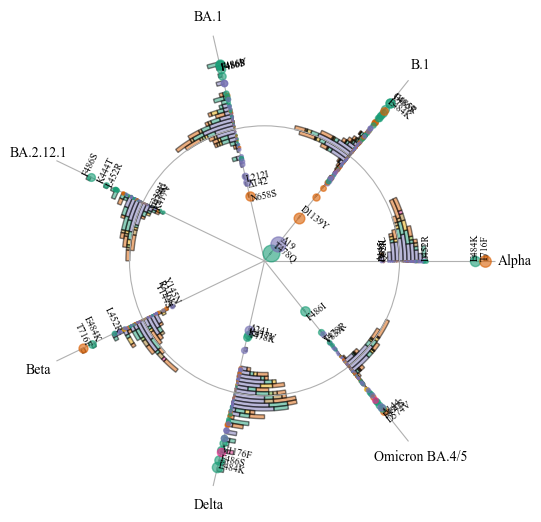

In [42]:
def bin_data(df, n_bins, binlim):
    bins = np.linspace(binlim[0], binlim[1], n_bins + 1)
    counts, _ = np.histogram(df['Effect'], bins=bins)
    return counts, bins

def draw_arc(ax, r_inner, r_outer, theta_start, theta_end, color='skyblue', edgecolor='black', alpha=0.8, n_points=100):
    # Outer arc
    theta_outer = np.linspace(theta_start, theta_end, n_points)
    r_outer_arc = np.full_like(theta_outer, r_outer)

    # Inner arc (reversed)
    theta_inner = np.linspace(theta_end, theta_start, n_points)
    r_inner_arc = np.full_like(theta_inner, r_inner)

    # Combine into closed polygon
    theta_full = np.concatenate([theta_outer, theta_inner])
    r_full = np.concatenate([r_outer_arc, r_inner_arc])

    ax.fill(theta_full, r_full, facecolor=color, edgecolor=edgecolor, alpha=alpha)

def draw_hist(df, ax, max_count=None, theta_start=0, n_bins=40, binlim=(-1.5, 1.5), 
              max_bin_angle=np.pi/4, region_palette=None, hue_order=None, alpha=0.8):
    counts_total, bins = bin_data(df, n_bins, binlim)
    max_count = counts_total.max() if max_count is None else max_count
    bin_edges = bins

    for i in range(len(bin_edges) - 1):
        r_inner = bin_edges[i]
        r_outer = bin_edges[i + 1]

        # Subset to current bin
        bin_mask = (df['Effect'] >= r_inner) & (df['Effect'] < r_outer)
        df_bin = df[bin_mask]

        total_bin_count = len(df_bin)
        if total_bin_count == 0:
            continue

        # Start stacking from theta_start
        theta_current = theta_start
        for region in hue_order:
            df_region = df_bin[df_bin['Region'] == region]
            region_count = len(df_region)
            if region_count == 0:
                continue
            theta_width = (region_count / max_count) * max_bin_angle if max_count > 0 else 0
            theta_end = theta_current + theta_width
            if theta_width > 0:
                draw_arc(
                    ax, r_inner, r_outer,
                    theta_current, theta_end,
                    color=region_palette[region],
                    alpha=alpha
                )
                theta_current = theta_end
            
def handle_alignment(angle):
    va='center'
    ha='center'
    if np.sin(angle) < np.sqrt(2)/2 and np.sin(angle) > -np.sqrt(2)/2:
        va='bottom'
    if np.cos(angle) < np.sqrt(2)/2 and np.cos(angle) > -np.sqrt(2)/2:
        ha='left'
    rotation = angle*360/(2*np.pi) + 90
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180   # Need to do it twice
    return va, ha, rotation

def draw_points(df, ax, region_palette, ms=12):
    for _, row in df.iterrows():
        ax.plot(row['Angle'], row['Effect'], 
                marker='o', color=region_palette[row['Region']], alpha=0.6, 
                markersize=np.abs(row['Effect'])*ms/max_effect)
        
def label_n(df, n, ax, fs=12):
    # Top n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').head(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect, 
                va=va, ha=ha, rotation=rot);
    # Bottom n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').tail(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect_by_pool[row['Pool']], 
                va=va, ha=ha, rotation=rot);
        
def clean_ax(pools, ax):
    ax.legend().set_visible(False);
    ax.set_xticks(angles[:len(pools)]);
    ax.set_xticklabels(pools);
    ax.spines['polar'].set_visible(False);
    ax.set_yticks([0]); ax.set_yticklabels([]);
    
def get_positions(mutations):
    coefficients = mutations.copy()
    
    positions = [int(''.join(filter(str.isdigit, c))) for c in coefficients] #[int(c[1:-1]) for c in coefficients]
    return positions, coefficients

def get_region(position):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    for r, v in regions.items():
        if position >= v[0] and position <= v[1]:
            return r
    return 'Other'

region_palette = dict({r:c for r,c in zip(['RBD', 'Other', 'NTD', 'HR2', 'FP', 'FCS', 'HR1', 'IFP'], sns.color_palette('Dark2'))})

pool_specific_effects['Position'], _ = get_positions(pool_specific_effects['Mutation'].tolist())
pool_specific_effects['Region'] = pool_specific_effects['Position'].apply(lambda x: get_region(x))

pools = pool_colors.keys()
angles = np.linspace(0, 2 * np.pi, len(pools), endpoint=False).tolist()
fs=7
ms=12

pool_specific_effects_polar = pool_specific_effects.copy()
pool_specific_effects_polar['Angle'] = pool_specific_effects['Pool'].apply(lambda x: dict({p:a for p, a in zip(pools, angles)})[x])

max_effect = np.abs(pool_specific_effects['Effect']).max()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw points
draw_points(pool_specific_effects, ax, region_palette, ms=ms)

# Label top / bottom n
n = 3
label_n(pool_specific_effects, n, ax, fs=fs)

# Clean ax
clean_ax(pools, ax);

# Hist
angle_width = 2*np.pi/len(pools)
n_bins=60
max_bin_angle = angle_width*0.5
rmin = ax.get_rmin(); rmax = ax.get_rmax();
binlim = [rmin, rmax]
counts = np.array([bin_data(pool_specific_effects[pool_specific_effects['Pool']==p], n_bins, binlim)[0] for p in pools])
hue_order=['NTD', 'RBD', 'FCS', 'FP', 'IFP', 'HR1', 'HR2', 'Other']
for i, (pool, color) in enumerate(pool_colors.items()):
    test_df = pool_specific_effects[pool_specific_effects['Pool']==pool]
    draw_hist(test_df, ax, 
              # max_count=counts.max(),
              theta_start=i*angle_width, 
              n_bins=n_bins, 
              binlim=binlim,
              max_bin_angle=max_bin_angle, 
              alpha=0.5,
              region_palette=region_palette,
              hue_order=hue_order);
    ax.set_rmin(rmin); ax.set_rmax(rmax);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

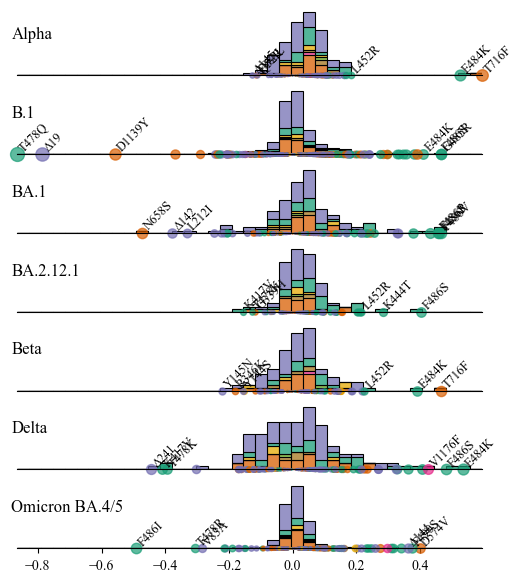

In [43]:
n_rows = len(pool_colors)
fig, axes = plt.subplots(n_rows, 1, figsize=(6, 1*(n_rows)))
ms = 10
fs = 12

xmin = pool_specific_effects['Effect'].min()
xmax = pool_specific_effects['Effect'].max()
max_effect = np.max([np.abs(pool_specific_effects['Effect'].min()), np.abs(pool_specific_effects['Effect'].max())])
bins = np.linspace(xmin, xmax, 40)

for i, (pool, color) in enumerate(pool_colors.items()):
    ax = axes[i]
    sns.histplot(x='Effect',
                 hue='Region',
                 data=pool_specific_effects[pool_specific_effects['Pool']==pool],
                 palette=region_palette,
                 hue_order=hue_order,
                 bins=bins,
                 multiple='stack',
                 ax=ax)
    
    for _, row in pool_specific_effects[pool_specific_effects['Pool']==pool].iterrows():
        ax.plot(row['Effect'], 0, 
                marker='o', markersize=ms*np.sqrt(np.abs(row['Effect'])/max_effect), 
                color=region_palette[row['Region']], alpha=0.7,
                clip_on=False)
    
    n = 3
    for _, row in pool_specific_effects[pool_specific_effects['Pool']==pool].sort_values(by='Effect').reset_index(drop=True).head(n).iterrows():
        ax.text(row['Effect'], 0, row['Mutation'],
                rotation=45, fontsize=0.75*fs, va='bottom', ha='left')
    for _, row in pool_specific_effects[pool_specific_effects['Pool']==pool].sort_values(by='Effect').reset_index(drop=True).tail(n).iterrows():
        ax.text(row['Effect'], 0, row['Mutation'],
                rotation=45, fontsize=0.75*fs, va='bottom', ha='left')
    
    ax.legend().set_visible(False);
    
    ax.set_ylabel(pool, rotation=0, ha='left', fontsize=fs);
    ax.spines[['left', 'right', 'top']].set_visible(False);
    ax.set_yticks([]);
    ax.set_xlabel('');
    ax.set_xlim([xmin, xmax]);
    
    if i!=n_rows-1:
        ax.set_xticks([]);

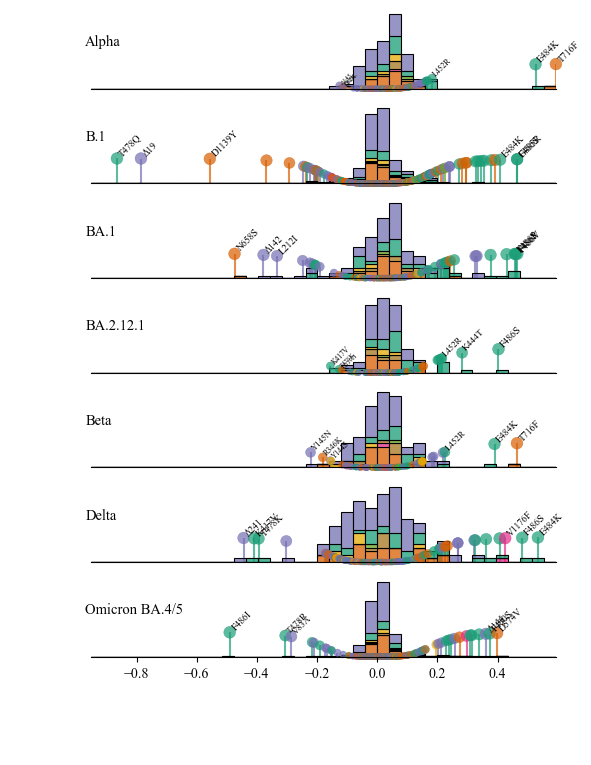

In [44]:
def lollipop(df1, ax, orientation='horizontal', space_func=None, labels=False, top_n=300, color_palette='Dark2', ms=8, fs=8):
    # Copy df
    df = df1.copy()
    
    # Calculate x positions
    if not space_func:
        def space_func(x):
            def degree_func(d, x_init:np.array):
                x = np.zeros(x_init.shape)
                for i in range(d):
                    deg = 2*i + 1
                    x += 10**(deg-1)*x_init**deg
                return x
            return degree_func(4, x)
    df = df.sort_values(by='Effect').reset_index(drop=True)
    df['x'] = space_func(df['Effect'].values)
    
    # Create color palette
    if not isinstance(color_palette, dict):
        regions = df['Region'].unique()
        color_palette = dict({r:c for r, c in zip(regions, sns.color_palette(color_palette, len(regions)))})
    
    # Set correct orientation
    if orientation == 'horizontal':
        x='Effect'
        y='x'
        stem = ax.vlines
        text_offset = [0, 1]
        text_rot = 45
        text_va = ['bottom', 'top']
        text_ha = ['left', 'right']
    elif orientation == 'vertical':
        x='x'
        y='Effect'
        stem = ax.hlines
        text_offset = [1, 0]
        text_rot = 0
        text_va = ['center', 'center']
        text_ha = ['left', 'right']
    else:
        raise ValueError('orientation must be set to horizontal or vertical')
    
    # Plot dots
    df['markersize'] = np.abs(df['x']); df['markersize'] = df['markersize'] * (ms / df['markersize'].max())
        
    sns.scatterplot(x=x,
                    y=y,
                    data=df,
                    hue='Region',
                    size='markersize',
                    palette=color_palette,
                    edgecolor=None,
                    alpha=0.7,
                    clip_on=False,
                    ax=ax)
    # Plot poles
    for _, row in df.iterrows():
        if orientation=='horizontal':
            stem(row['Effect'], 0, row['x'], color=color_palette[row['Region']], alpha=0.7, zorder=-1);
        elif orientation=='vertical':
            stem(row['x'], 0, row['Effect'], color=color_palette[row['Region']], alpha=0.7, zorder=-1);
            
    # Add labels
    if labels:
        df['fontsize'] = np.abs(df['x'])**(1/5); df['fontsize'] = df['fontsize'] * (fs / df['fontsize'].max())
        # df['fontsize'] = df['fontsize'].apply(lambda x: np.sqrt(x))
        text_buffer = 0.015
        for _, row in df.head(top_n).iterrows():
            ax.text(row[x] + text_buffer*text_offset[0], 
                    row[y] + text_buffer*text_offset[1], 
                    row['Mutation'], 
                    ha='left', va='bottom', rotation=45, fontsize=row['fontsize'])
        for _, row in df.tail(top_n).iterrows():
            ax.text(row[x] - text_buffer*text_offset[0], 
                    row[y] - text_buffer*text_offset[1], 
                    row['Mutation'], 
                    ha='left', va='bottom', rotation=45, fontsize=row['fontsize'])

    # Format axis
    if orientation == 'horizontal':
        ax.spines[['bottom']].set_position('zero');
        ax.spines[['top', 'right']].set_visible(False);
        ax.legend().set_visible(False);
    elif orientation == 'vertical':
        ax.spines[['left']].set_position('zero');
        ax.spines[['top', 'right']].set_visible(False);
        ylim = ax.get_ylim(); ax.set_ylim(ylim[1], ylim[0]);
        ax.legend().set_visible(False);
    
    return df, color_palette

def space_func(x, a, k):
    kern = (x/a)**4 / ((x/a)**4 + 1)
    return k * kern

n_rows = len(pool_colors)
fig, axes = plt.subplots(n_rows, 1, figsize=(6, 1.2*(n_rows)))
ms = 12
fs = 7

xmin = 1.1*pool_specific_effects['Effect'].min()
xmax = pool_specific_effects['Effect'].max()
max_effect = np.max([np.abs(pool_specific_effects['Effect'].min()), np.abs(pool_specific_effects['Effect'].max())])
bins = np.linspace(xmin, xmax, 40)

for i, (pool, color) in enumerate(pool_colors.items()):
    ax = axes[i]
    temp_df = pool_specific_effects[pool_specific_effects['Pool']==pool]
    sns.histplot(x='Effect',
                 hue='Region',
                 data=temp_df,
                 palette=region_palette,
                 hue_order=hue_order,
                 bins=bins,
                 multiple='stack',
                 ax=ax)
    
    n = 3
    k = np.histogram(temp_df['Effect'], bins=bins)[0].max() / 3
    _, _ = lollipop(temp_df, ax, labels=True, space_func=lambda x: space_func(x, 0.2, k), top_n=n, color_palette=region_palette, fs=fs, ms=ms)
    
    ax.legend().set_visible(False);
    
    ax.set_ylabel(pool, rotation=0, ha='left', fontsize=fs*1.5);
    ax.spines[['left', 'right', 'top']].set_visible(False);
    ax.set_yticks([]);
    ax.set_xlabel('');
    ax.set_xlim([xmin, xmax]);
    
    if i!=n_rows-1:
        ax.set_xticks([]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


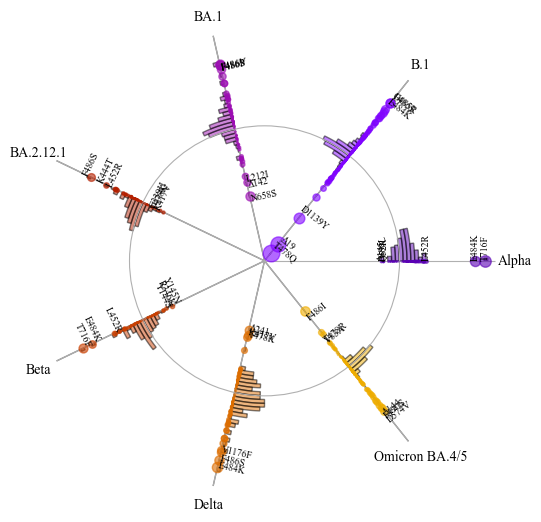

In [45]:
def bin_data(df, n_bins, binlim):
    bins = np.linspace(binlim[0], binlim[1], n_bins + 1)
    counts, _ = np.histogram(df['Effect'], bins=bins)
    return counts, bins

def draw_arc(ax, r_inner, r_outer, theta_start, theta_end, color='skyblue', edgecolor='black', alpha=0.8, n_points=100):
    # Outer arc
    theta_outer = np.linspace(theta_start, theta_end, n_points)
    r_outer_arc = np.full_like(theta_outer, r_outer)

    # Inner arc (reversed)
    theta_inner = np.linspace(theta_end, theta_start, n_points)
    r_inner_arc = np.full_like(theta_inner, r_inner)

    # Combine into closed polygon
    theta_full = np.concatenate([theta_outer, theta_inner])
    r_full = np.concatenate([r_outer_arc, r_inner_arc])

    ax.fill(theta_full, r_full, facecolor=color, edgecolor=edgecolor, alpha=alpha)

def draw_hist(df, ax, max_count=None, theta_start=0, n_bins=40, binlim=(-1.5, 1.5), max_bin_angle=np.pi/4, color='skyblue', alpha=0.8):
    counts, bins = bin_data(df, n_bins, binlim)
    max_count = counts.max() if not max_count else max_count
    bin_edges = bins
    for i in range(len(bin_edges) - 1):
        r_inner = bin_edges[i]
        r_outer = bin_edges[i + 1]
        theta_end = theta_start + (counts[i] / max_count) * max_bin_angle if max_count > 0 else 0
        if theta_end > 0:
            draw_arc(ax, r_inner, r_outer, theta_start, theta_end, color=color, alpha=alpha)
            
def handle_alignment(angle):
    va='center'
    ha='center'
    if np.sin(angle) < np.sqrt(2)/2 and np.sin(angle) > -np.sqrt(2)/2:
        va='bottom'
    if np.cos(angle) < np.sqrt(2)/2 and np.cos(angle) > -np.sqrt(2)/2:
        ha='left'
    rotation = angle*360/(2*np.pi) + 90
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180   # Need to do it twice
    return va, ha, rotation

def draw_points(df, ax, ms=12):
    for _, row in df.iterrows():
        ax.plot(row['Angle'], row['Effect'], 
                marker='o', color=pool_colors[row['Pool']], alpha=0.6, 
                markersize=np.abs(row['Effect'])*ms/max_effect)
        
def label_n(df, n, ax, fs=12):
    # Top n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').head(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect, 
                va=va, ha=ha, rotation=rot);
    # Bottom n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').tail(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect_by_pool[row['Pool']], 
                va=va, ha=ha, rotation=rot);
        
def clean_ax(pools, ax):
    ax.legend().set_visible(False);
    ax.set_xticks(angles[:len(pools)]);
    ax.set_xticklabels(pools);
    ax.spines['polar'].set_visible(False);
    ax.set_yticks([0]); ax.set_yticklabels([]);
        
pools = pool_colors.keys()
angles = np.linspace(0, 2 * np.pi, len(pools), endpoint=False).tolist()
fs=7
ms=12

pool_specific_effects_polar = pool_specific_effects
pool_specific_effects_polar['Angle'] = pool_specific_effects['Pool'].apply(lambda x: dict({p:a for p, a in zip(pools, angles)})[x])

max_effect = np.abs(pool_specific_effects['Effect']).max()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw points
draw_points(pool_specific_effects, ax, ms=ms)

# Label top / bottom n
n = 3
label_n(pool_specific_effects, n, ax, fs=fs)

# Clean ax
clean_ax(pools, ax);

# Hist
angle_width = 2*np.pi/len(pools)
n_bins=60
max_bin_angle = angle_width*0.25
rmin = ax.get_rmin(); rmax = ax.get_rmax();
binlim = [rmin, rmax]
counts = np.array([bin_data(pool_specific_effects[pool_specific_effects['Pool']==p], n_bins, binlim)[0] for p in pools])
for i, (pool, color) in enumerate(pool_colors.items()):
    test_df = pool_specific_effects[pool_specific_effects['Pool']==pool]
    draw_hist(test_df, ax, 
              # max_count=counts.max(),
              theta_start=i*angle_width, 
              n_bins=n_bins, 
              binlim=binlim,
              max_bin_angle=max_bin_angle, 
              alpha=0.5,
              color=color);
    ax.set_rmin(rmin); ax.set_rmax(rmax);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


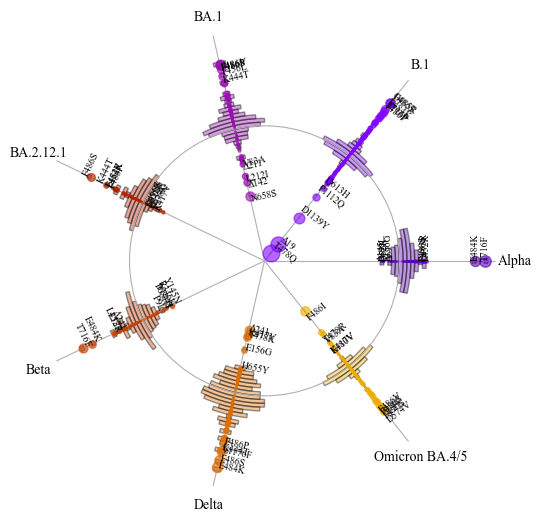

In [46]:
def bin_data(df, n_bins, binlim):
    bins = np.linspace(binlim[0], binlim[1], n_bins + 1)
    counts, _ = np.histogram(df['Effect'], bins=bins)
    return counts, bins

def draw_arc(ax, r_inner, r_outer, theta_start, theta_end, color='skyblue', edgecolor='black', alpha=0.8, n_points=100):
    # Outer arc
    theta_outer = np.linspace(theta_start, theta_end, n_points)
    r_outer_arc = np.full_like(theta_outer, r_outer)

    # Inner arc (reversed)
    theta_inner = np.linspace(theta_end, theta_start, n_points)
    r_inner_arc = np.full_like(theta_inner, r_inner)

    # Combine into closed polygon
    theta_full = np.concatenate([theta_outer, theta_inner])
    r_full = np.concatenate([r_outer_arc, r_inner_arc])

    ax.fill(theta_full, r_full, facecolor=color, edgecolor=edgecolor, alpha=alpha)

def draw_hist(df, ax, max_count=None, theta_mean=0, n_bins=40, binlim=(-1.5, 1.5), max_bin_angle=np.pi/4, color='skyblue', alpha=0.8):
    counts, bins = bin_data(df, n_bins, binlim)
    max_count = counts.max() if not max_count else max_count
    bin_edges = bins
    
    for i in range(len(bin_edges) - 1):
        r_inner = bin_edges[i]
        r_outer = bin_edges[i + 1]
        theta_width = (counts[i] / max_count) * max_bin_angle if max_count > 0 else 0
        if theta_width > 0:
            theta_start = theta_mean - theta_width / 2
            theta_end = theta_mean + theta_width / 2
            draw_arc(ax, r_inner, r_outer, theta_start, theta_end, color=color, alpha=alpha)
            
def handle_alignment(angle):
    va='center'
    ha='center'
    if np.sin(angle) < np.sqrt(2)/2 and np.sin(angle) > -np.sqrt(2)/2:
        va='bottom'
    if np.cos(angle) < np.sqrt(2)/2 and np.cos(angle) > -np.sqrt(2)/2:
        ha='left'
    rotation = angle*360/(2*np.pi) + 90
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180   # Need to do it twice
    return va, ha, rotation

def draw_points(df, ax, ms=12):
    for _, row in df.iterrows():
        ax.plot(row['Angle'], row['Effect'], 
                marker='o', color=pool_colors[row['Pool']], alpha=0.6, 
                markersize=np.abs(row['Effect'])*ms/max_effect)
        
def label_n(df, n, ax, fs=12):
    # Top n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').head(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect, 
                va=va, ha=ha, rotation=rot);
    # Bottom n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').tail(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect_by_pool[row['Pool']], 
                va=va, ha=ha, rotation=rot);
        
def clean_ax(pools, ax):
    ax.legend().set_visible(False);
    ax.set_xticks(angles[:len(pools)]);
    ax.set_xticklabels(pools);
    ax.spines['polar'].set_visible(False);
    ax.set_yticks([0]); ax.set_yticklabels([]);
        
pools = pool_colors.keys()
angles = np.linspace(0, 2 * np.pi, len(pools), endpoint=False).tolist()
fs=7
ms=12

pool_specific_effects_polar = pool_specific_effects
pool_specific_effects_polar['Angle'] = pool_specific_effects['Pool'].apply(lambda x: dict({p:a for p, a in zip(pools, angles)})[x])

max_effect = np.abs(pool_specific_effects['Effect']).max()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw points
draw_points(pool_specific_effects, ax, ms=ms)

# Label top / bottom n
n = 5
label_n(pool_specific_effects, n, ax, fs=fs)

# Clean ax
clean_ax(pools, ax);

# Hist
angle_width = 2*np.pi/len(pools)
n_bins=60
max_bin_angle = angle_width*0.5
rmin = ax.get_rmin(); rmax = ax.get_rmax();
binlim = [rmin, rmax]
counts = np.array([bin_data(pool_specific_effects[pool_specific_effects['Pool']==p], n_bins, binlim)[0] for p in pools])
for i, (pool, color) in enumerate(pool_colors.items()):
    test_df = pool_specific_effects[pool_specific_effects['Pool']==pool]
    draw_hist(test_df, ax, 
              # max_count=counts.max(),
              theta_mean=i*angle_width, 
              n_bins=n_bins, 
              binlim=binlim,
              max_bin_angle=max_bin_angle, 
              alpha=0.4,
              color=color);
    ax.set_rmin(rmin); ax.set_rmax(rmax);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


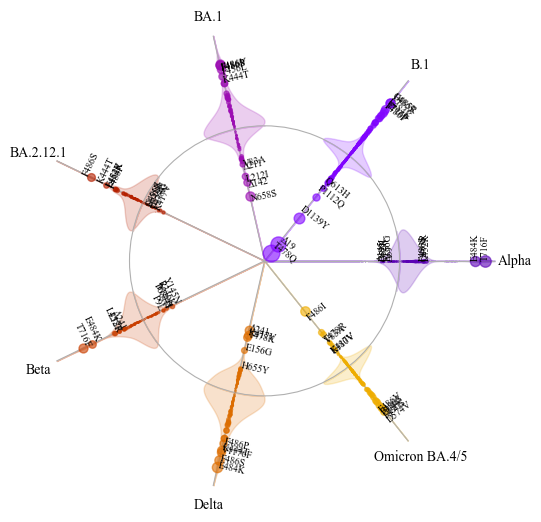

In [47]:
def kde_effects(df, ax, angle=0, color='skyblue', alpha=0.4, binlim=[-1.5, 1.5], max_angle=0.5*np.pi/4, lw=0.5):
    effects = df['Effect'].dropna().values
    
    # KDE
    kde = gaussian_kde(effects)
    r = np.linspace(*binlim, 200)
    density = kde(r)
    
    # Normalize density to max angular width
    scale = max_angle / max(density)
    theta = density * scale
    theta_top = theta + angle  # rotate by angle
    theta_bottom = -theta + angle  # rotate by angle
    
    # Plot in polar coordinates
    ax.plot(theta_top, r, color=color, lw=lw)
    ax.plot(theta_bottom, r, color=color, lw=lw)
    ax.fill_between(theta_top, 0, r, alpha=alpha, color=color)
    ax.fill_between(theta_bottom, 0, r, alpha=alpha, color=color)
    ax.set_rlim(binlim)
            
def handle_alignment(angle):
    va='center'
    ha='center'
    if np.sin(angle) < np.sqrt(2)/2 and np.sin(angle) > -np.sqrt(2)/2:
        va='bottom'
    if np.cos(angle) < np.sqrt(2)/2 and np.cos(angle) > -np.sqrt(2)/2:
        ha='left'
    rotation = angle*360/(2*np.pi) + 90
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180
    rotation = rotation if rotation<=90 and rotation>=-90 else rotation-180   # Need to do it twice
    return va, ha, rotation

def draw_points(df, ax, ms=12):
    for _, row in df.iterrows():
        ax.plot(row['Angle'], row['Effect'], 
                marker='o', color=pool_colors[row['Pool']], alpha=0.6, 
                markersize=np.abs(row['Effect'])*ms/max_effect)
        
def label_n(df, n, ax, fs=12):
    # Top n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').head(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect, 
                va=va, ha=ha, rotation=rot);
    # Bottom n
    for _, row in df.sort_values(['Pool', 'Effect']).groupby('Pool').tail(n).iterrows():
        va, ha, rot = handle_alignment(row['Angle'])
        ax.text(row['Angle'], row['Effect'], row['Mutation'], 
                fontsize=fs,#np.abs(row['Effect'])*fs/max_effect_by_pool[row['Pool']], 
                va=va, ha=ha, rotation=rot);
        
def clean_ax(pools, ax):
    ax.legend().set_visible(False);
    ax.set_xticks(angles[:len(pools)]);
    ax.set_xticklabels(pools);
    ax.spines['polar'].set_visible(False);
    ax.set_yticks([0]); ax.set_yticklabels([]);
        
pools = pool_colors.keys()
angles = np.linspace(0, 2 * np.pi, len(pools), endpoint=False).tolist()
fs=7
ms=12

pool_specific_effects_polar = pool_specific_effects
pool_specific_effects_polar['Angle'] = pool_specific_effects['Pool'].apply(lambda x: dict({p:a for p, a in zip(pools, angles)})[x])

max_effect = np.abs(pool_specific_effects['Effect']).max()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw points
draw_points(pool_specific_effects, ax, ms=ms)

# Label top / bottom n
n = 5
label_n(pool_specific_effects, n, ax, fs=fs)

# Clean ax
clean_ax(pools, ax);

# KDE
angle_width = 2*np.pi/len(pools)
max_angle = angle_width*0.25
rmin = ax.get_rmin(); rmax = ax.get_rmax();
binlim = [rmin, rmax]
for i, (pool, color) in enumerate(pool_colors.items()):
    test_df = pool_specific_effects[pool_specific_effects['Pool'] == pool]
    kde_effects(test_df, ax, angle=angles[i], color=color, binlim=[rmin, rmax], max_angle=max_angle, alpha=0.2, lw=0)
    ax.set_rmin(rmin); ax.set_rmax(rmax);
    
    

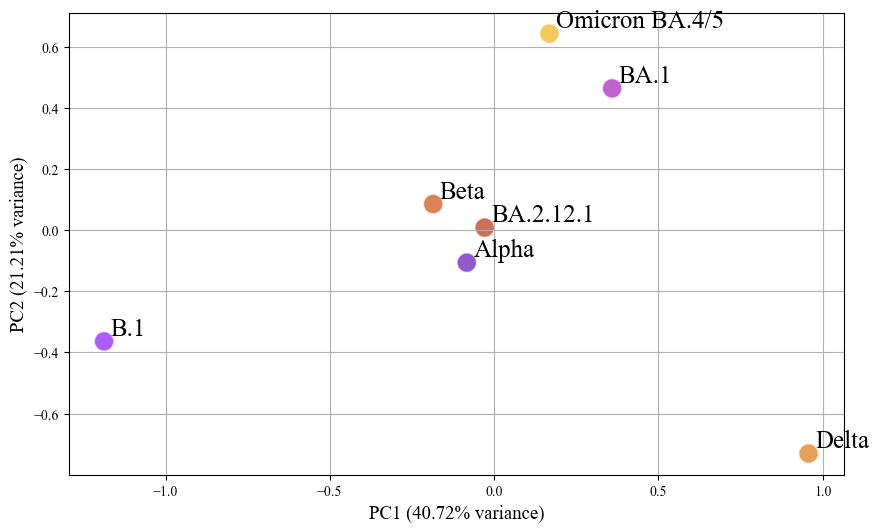

In [48]:
# Can we do PCA on the immune responses to cluster...?
pool_specific_effects_piv = pool_specific_effects[['Pool', 'Mutation', 'Effect']].pivot(columns='Pool', index='Mutation', values='Effect')
pool_specific_effects_piv['mean'] = pool_specific_effects_piv.apply(lambda row: row.mean(), axis=1)
n = 20
# pool_specific_effects_piv = pd.concat([pool_specific_effects_piv.sort_values(by='mean', ascending=False).head(n),
#                                        pool_specific_effects_piv.sort_values(by='mean', ascending=False).tail(n)])
# pool_specific_effects_piv = pool_specific_effects_piv.fillna(0)
pool_specific_effects_piv = pool_specific_effects_piv.T.fillna(pool_specific_effects_piv['mean'].T).T
pool_specific_effects_piv = pool_specific_effects_piv.drop(columns='mean');

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# import seaborn as sns

# Transpose so rows = variants (Pools), columns = features (Mutations)
X = pool_specific_effects_piv.T

# Standardize the data (important for PCA)
X_scaled = X# StandardScaler().fit_transform(X)

# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a dataframe for plotting
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'], index=X.index).reset_index()

# Plot
fs = 18
ms = 200
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='PC1',
                y='PC2',
                hue='Pool',
                data=pca_df,
                s=ms,
                palette=pool_colors,
                alpha=0.65,
                ax=ax)
for _, (label, x, y) in pca_df.iterrows():
    ax.text(x + 0.02, y + 0.02, label, fontsize=fs)
# ax.set_title("PCA of Pools based on Mutation Effects", fontsize=fs*0.85)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)", fontsize=fs*0.75)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)", fontsize=fs*0.75)
ax.grid(True)
ax.legend().set_visible(False);

In [49]:
def get_region(position):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    for r, v in regions.items():
        if position >= v[0] and position <= v[1]:
            return r
    return 'Other'

pool_effect_differences_df_withpos['Region'] = pool_effect_differences_df_withpos['Position'].apply(lambda x: get_region(x))
pool_effect_differences_by_region = pool_effect_differences_df_withpos[['Pool', 'Region', 'Effect difference']].groupby(['Pool', 'Region']).agg(['mean','max']).reset_index()
pool_effect_differences_by_region.columns = ['Pool', 'Region', 'Mean Effect Difference', 'Max Effect Difference']

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_40464/522963799.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  trace = escape_traces['β_ω'][:, pool_idx, mut_idx]


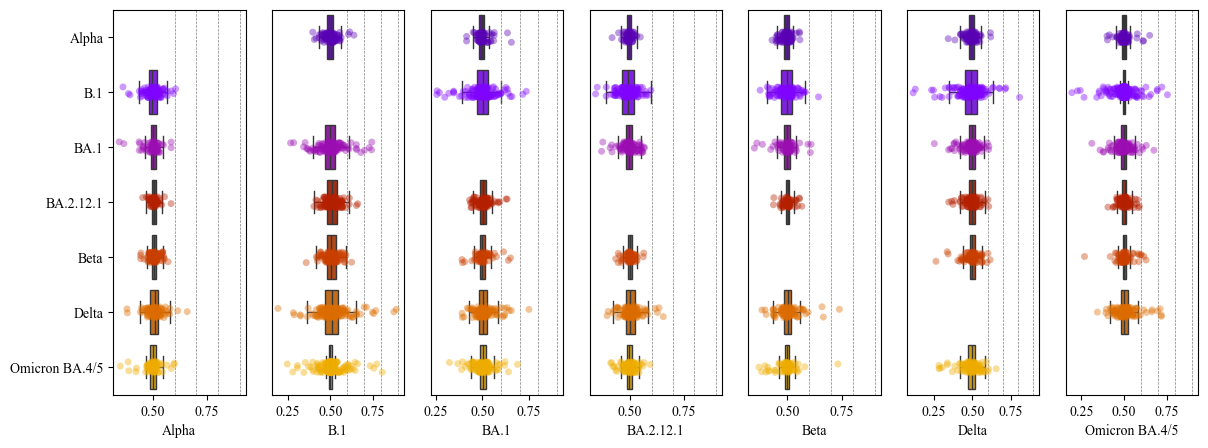

In [50]:
# Take a random variable approach to calculating effect ranges
def get_trace_for_df(row):
    pool = row['Pool']
    mut = row['Mutation']
    pool_idx = np.where(escape_data['pools_map']==pool)
    mut_idx = escape_data['features'].index(mut)
    trace = escape_traces['β_ω'][:, pool_idx, mut_idx]
    return trace.squeeze()

# def range_rv(traces):
#     traces = traces.values.tolist()
#     traces = np.array(traces)
#     return traces
#     trace_means = traces.mean(axis=1)
#     max_trace_idx = np.where(trace_means == trace_means.max())
#     min_trace_idx = np.where(trace_means == trace_means.min())
#     # assert max_trace_idx < 10
#     max_trace = traces[max_trace_idx]
#     min_trace = traces[min_trace_idx]
#     range_trace = max_trace - min_trace
#     return range_trace.squeeze()
pool_specific_effects['trace'] = pool_specific_effects.apply(lambda row: get_trace_for_df(row), axis=1)
# mutation_effect_differences_rv = pool_specific_effects[['Mutation', 'Position', 'Region', 'trace']
#                                              ].groupby(['Mutation', 'Position', 'Region']
#                                              ).agg(lambda x: range_rv(x)
#                                              ).rename(columns={'trace':'Range (RV) trace'}
#                                              ).reset_index()
# mutation_effect_differences_rv = mutation_effect_differences_rv[~mutation_effect_differences_rv['Range (RV) trace'].apply(lambda x: np.all(x==0))]
# mutation_effect_differences_rv['Pr(Range > 0)'] = mutation_effect_differences_rv['Range (RV) trace'].apply(lambda x: (x>0).sum()/x.shape[0])
# mutation_effect_differences_rv = mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False)

def get_all_range_rv(series):
    pools = series['Pool'].values.tolist()
    traces = np.array(series['trace'].values.tolist())
    pairs = []
    if len(traces.shape)>1:
        for i in range(traces.shape[0]):
            for j in range(traces.shape[0]):
                if i!=j:
                    pool1 = pools[i]; pool2 = pools[j]
                    trace1 = traces[i]; trace2 = traces[j]
                    range_trace = trace1 - trace2
                    # Make sure we take max trace - min trace
                    # range_trace = range_trace if range_trace.mean()>0 else -range_trace
                    pairs.append({', '.join([pool1, pool2]) : range_trace})
                    # pairs[', '.join(sorted([pool1, pool2]))] = range_trace
    return pairs
    
mutation_effect_differences_rv = pool_specific_effects[['Mutation', 'Position', 'Region', 'Pool', 'trace']
                                             ].groupby(['Mutation', 'Position', 'Region']
                                             ).apply(lambda x: get_all_range_rv(x)
                                             ).reset_index(
                                             ).rename(columns={0:'pools/range trace dict'}
                                             ).explode('pools/range trace dict'
                                             ).dropna()
mutation_effect_differences_rv['Pools'] = mutation_effect_differences_rv['pools/range trace dict'].apply(lambda x: list(x.keys())[0])
mutation_effect_differences_rv['Pool 1'] = mutation_effect_differences_rv['Pools'].apply(lambda x: x.split(', ')[0])
mutation_effect_differences_rv['Pool 2'] = mutation_effect_differences_rv['Pools'].apply(lambda x: x.split(', ')[1])
mutation_effect_differences_rv['Range (RV) trace'] = mutation_effect_differences_rv['pools/range trace dict'].apply(lambda x: list(x.values())[0])
# mutation_effect_differences_rv = mutation_effect_differences_rv.drop(columns=['pools/range trace dict', 'Pools'])
mutation_effect_differences_rv['Pr(Range > 0)'] = mutation_effect_differences_rv['Range (RV) trace'].apply(lambda x: (x>0).sum()/x.shape[0])
mutation_effect_differences_rv = mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False)

# fig, ax = plt.subplots()
# sns.histplot(x='Pr(Range > 0)',
#              hue='Pools',
#              data=mutation_effect_differences_rv,
#              ax=ax);
# ax.set_yscale('log');
# legend = ax.get_legend()
# legend.set_bbox_to_anchor((1, 1))

nrow = len(varns)
fig, axes = plt.subplots(1, nrow, figsize=(2*nrow, 5))
for i, p in enumerate(varns):
    ax = axes[i]
    df_temp = mutation_effect_differences_rv[mutation_effect_differences_rv['Pool 1']==p]
    sns.boxplot(y='Pool 2',
                x='Pr(Range > 0)',
                hue='Pool 2',
                order=varns,
                data=df_temp,
                showfliers=False,
                palette=pool_colors,
                ax=ax)
    sns.stripplot(y='Pool 2',
                x='Pr(Range > 0)',
                hue='Pool 2',
                order=varns,
                data=df_temp,
                jitter=True,
                alpha=0.4,
                palette=pool_colors,
                ax=ax)
    ax.set_xlabel(p);
    ax.set_ylabel('');
    
    ax.vlines([0.6, 0.7, 0.8, 0.9], 0-0.5, len(varns)-0.5,
             linestyle='--', color='gray', linewidth=0.5);
    ax.set_ylim([len(varns)-0.5, 0-0.5]);
    
    if i!=0:
        ax.set_yticks([]);
# fig.tight_layout();
# mutation_effect_differences_rv

In [61]:
mutation_effect_differences_rv

Mutation  Position Region  \
252    K417V       417    RBD   
610    T478K       478    RBD   
637   V1176F      1176    HR2   
252    K417V       417    RBD   
610    T478K       478    RBD   
..       ...       ...    ...   
610    T478K       478    RBD   
252    K417V       417    RBD   
637   V1176F      1176    HR2   
610    T478K       478    RBD   
252    K417V       417    RBD   

                                pools/range trace dict                Pools  \
252  {'B.1, Delta': [0.3961116, 0.37125772, 0.63436...           B.1, Delta   
610  {'B.1, Delta': [0.41067046, 0.45893174, 0.8768...           B.1, Delta   
637  {'Delta, B.1': [-0.013822854, -0.1144889, 1.77...           Delta, B.1   
252  {'B.1, Omicron BA.4/5': [0.9383507, 0.8121309,...  B.1, Omicron BA.4/5   
610  {'B.1, Omicron BA.4/5': [0.58031857, 0.3790834...  B.1, Omicron BA.4/5   
..                                                 ...                  ...   
610  {'Omicron BA.4/5, B.1': [-0.58031857, -0.37908...  Omicron BA.4/5, B.1   
252  {'Omicron BA.4/5, B.1': [-0.9383507, -0.812130...  Omicron BA.4/5, B.1   
637  {'B.1, Delta': [0.013822854, 0.1144889, -1.770...           B.1, Delta   
610  {'Delta, B.1': [-0.41067046, -0.45893174, -0.8...           Delta, B.1   
252  {'Delta, B.1': [-0.3961116, -0.37125772, -0.63...           Delta, B.1   

             Pool 1          Pool 2  \
252             B.1           Delta   
610             B.1           Delta   
637           Delta             B.1   
252             B.1  Omicron BA.4/5   
610             B.1  Omicron BA.4/5   
..              ...             ...   
610  Omicron BA.4/5             B.1   
252  Omicron BA.4/5             B.1   
637             B.1           Delta   
610           Delta             B.1   
252           Delta             B.1   

                                      Range (RV) trace  Pr(Range > 0)  
252  [0.3961116, 0.37125772, 0.63436323, 0.3329736,...        0.88800  
610  [0.41067046, 0.45893174, 0.8768148, 0.99773633...        0.87400  
637  [-0.013822854, -0.1144889, 1.7707393, -0.28601...        0.80925  
252  [0.9383507, 0.8121309, 0.14673354, 0.31060404,...        0.80500  
610  [0.58031857, 0.37908345, 0.62512124, 0.8935165...        0.77325  
..                                                 ...            ...  
610  [-0.58031857, -0.37908345, -0.62512124, -0.893...        0.22675  
252  [-0.9383507, -0.8121309, -0.14673354, -0.31060...        0.19500  
637  [0.013822854, 0.1144889, -1.7707393, 0.2860184...        0.19075  
610  [-0.41067046, -0.45893174, -0.8768148, -0.9977...        0.12600  
252  [-0.3961116, -0.37125772, -0.63436323, -0.3329...        0.11200  

[5298 rows x 9 columns]

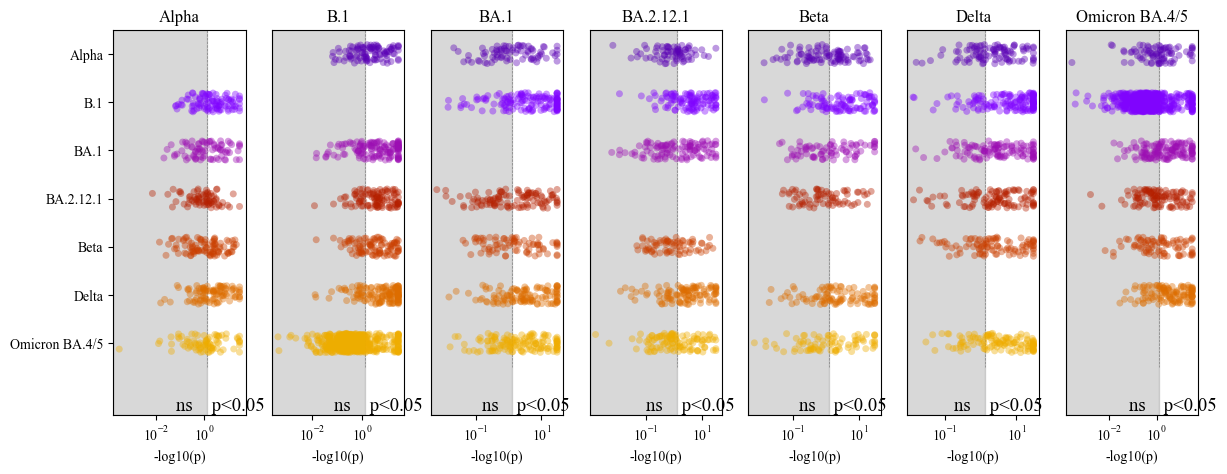

In [51]:
# Take a random variable approach to calculating effect ranges
def get_trace_for_df(row):
    pool = row['Pool']
    mut = row['Mutation']
    pool_idx = np.where(escape_data['pools_map']==pool)
    mut_idx = escape_data['features'].index(mut)
    trace = escape_traces['β_ω'][:, pool_idx, mut_idx]
    return trace.squeeze()

# def range_rv(traces):
#     traces = traces.values.tolist()
#     traces = np.array(traces)
#     return traces
#     trace_means = traces.mean(axis=1)
#     max_trace_idx = np.where(trace_means == trace_means.max())
#     min_trace_idx = np.where(trace_means == trace_means.min())
#     # assert max_trace_idx < 10
#     max_trace = traces[max_trace_idx]
#     min_trace = traces[min_trace_idx]
#     range_trace = max_trace - min_trace
#     return range_trace.squeeze()
pool_specific_effects['trace'] = pool_specific_effects.apply(lambda row: get_trace_for_df(row), axis=1)
# mutation_effect_differences_rv = pool_specific_effects[['Mutation', 'Position', 'Region', 'trace']
#                                              ].groupby(['Mutation', 'Position', 'Region']
#                                              ).agg(lambda x: range_rv(x)
#                                              ).rename(columns={'trace':'Range (RV) trace'}
#                                              ).reset_index()
# mutation_effect_differences_rv = mutation_effect_differences_rv[~mutation_effect_differences_rv['Range (RV) trace'].apply(lambda x: np.all(x==0))]
# mutation_effect_differences_rv['Pr(Range > 0)'] = mutation_effect_differences_rv['Range (RV) trace'].apply(lambda x: (x>0).sum()/x.shape[0])
# mutation_effect_differences_rv = mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False)

def get_all_range_t_test(series):
    pools = series['Pool'].values.tolist()
    traces = np.array(series['trace'].values.tolist())
    pairs = []
    if len(traces.shape)>1:
        for i in range(traces.shape[0]):
            for j in range(i+1, traces.shape[0]):
                pool1 = pools[i]; pool2 = pools[j]
                trace1 = traces[i]; trace2 = traces[j]
                stat, pval = ttest_rel(trace1, trace2)
                pairs.append({', '.join(sorted([pool1, pool2])) : pval})
                # pairs[', '.join(sorted([pool1, pool2]))] = range_trace
    return pairs
    
mutation_effect_differences_tt = pool_specific_effects[['Mutation', 'Position', 'Region', 'Pool', 'trace']
                                             ].groupby(['Mutation', 'Position', 'Region']
                                             ).apply(lambda x: get_all_range_t_test(x)
                                             ).reset_index(
                                             ).rename(columns={0:'pools/ttest dict'}
                                             ).explode('pools/ttest dict'
                                             ).dropna()
mutation_effect_differences_tt['Pools'] = mutation_effect_differences_tt['pools/ttest dict'].apply(lambda x: list(x.keys())[0])
mutation_effect_differences_tt['Pool 1'] = mutation_effect_differences_tt['Pools'].apply(lambda x: x.split(', ')[0])
mutation_effect_differences_tt['Pool 2'] = mutation_effect_differences_tt['Pools'].apply(lambda x: x.split(', ')[1])
mutation_effect_differences_tt['ttest_rel p'] = mutation_effect_differences_tt['pools/ttest dict'].apply(lambda x: list(x.values())[0])
mutation_effect_differences_tt['-log10(p)'] = mutation_effect_differences_tt['ttest_rel p'].apply(lambda x: min(30, -np.log10(x)))
# mutation_effect_differences_rv = mutation_effect_differences_rv.drop(columns=['pools/range trace dict', 'Pools'])
# mutation_effect_differences_rv['Pr(Range > 0)'] = mutation_effect_differences_rv['Range (RV) trace'].apply(lambda x: (x>0).sum()/x.shape[0])
mutation_effect_differences_tt = mutation_effect_differences_tt.sort_values(by='ttest_rel p', ascending=False)

# fig, ax = plt.subplots()
# sns.histplot(x='Pr(Range > 0)',
#              hue='Pools',
#              data=mutation_effect_differences_rv,
#              ax=ax);
# ax.set_yscale('log');
# legend = ax.get_legend()
# legend.set_bbox_to_anchor((1, 1))

nrow = len(varns)
fig, axes = plt.subplots(1, nrow, figsize=(2*nrow, 5))
for i, p in enumerate(varns):
    ax = axes[i]
    df_temp = mutation_effect_differences_tt[mutation_effect_differences_tt['Pools'].apply(lambda x: p in x)].copy()
    df_temp['Var'] = df_temp['Pools'].apply(lambda x: x.replace(p, '').replace(', ', ''))
    # sns.boxplot(y='Var',
    #             x='-log10(p)',
    #             hue='Var',
    #             order=varns,
    #             data=df_temp,
    #             showfliers=False,
    #             palette=pool_colors,
    #             ax=ax)
    sns.stripplot(y='Var',
                x='-log10(p)',
                hue='Var',
                order=varns,
                data=df_temp,
                jitter=0.2,
                alpha=0.4,
                palette=pool_colors,
                ax=ax)
    ax.set_title(p);
    ax.set_xlabel('-log10(p)');
    ax.set_ylabel('');
    ax.set_xscale('log');
    
    ax.vlines(-np.log10(0.05), 0-0.5, len(varns)-0.5,
             linestyle='--', color='gray', linewidth=0.5);
    ylim = [len(varns)+0.5, 0-0.5]
    ax.text(-np.log10(0.05), ylim[0], 'ns   ', ha='right', va='bottom', fontsize=fs*0.75)
    ax.text(-np.log10(0.05), ylim[0], ' p<0.05', ha='left', va='bottom', fontsize=fs*0.75)
    xlim = ax.get_xlim()
    ax.fill_between([xlim[0], -np.log10(0.05)], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=0.3);
    ax.set_xlim(xlim);
    ax.set_ylim(ylim);
    
    
    if i!=0:
        ax.set_yticks([]);
# fig.tight_layout();
# mutation_effect_differences_rv

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

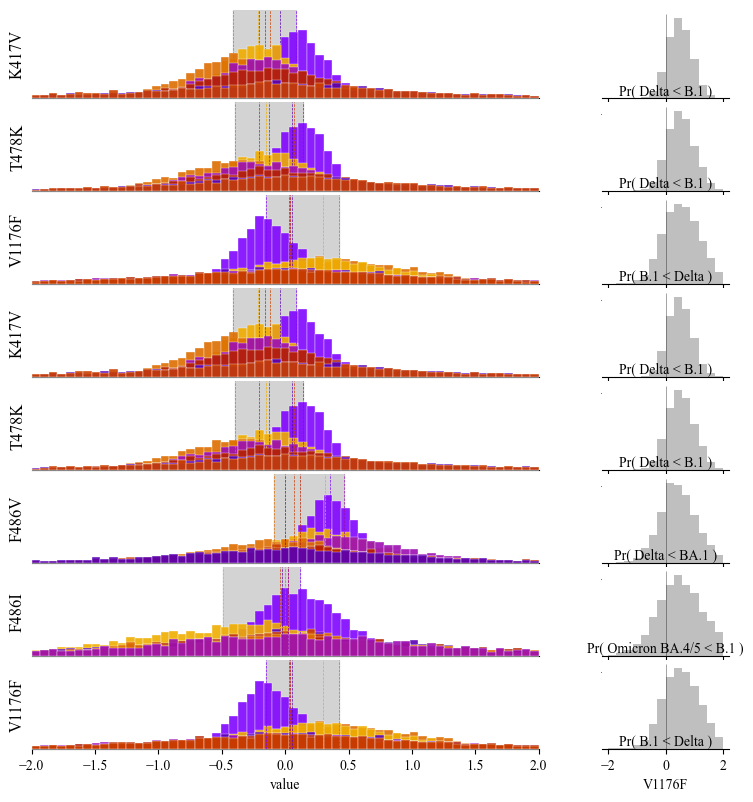

In [68]:
top_n = 8
top_n_muts = mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False).head(top_n)['Mutation'].tolist()
top_n_muts_idxs = [escape_data['features'].index(m) for m in top_n_muts]
top_n_muts_traces = escape_traces['β_ω'][:, :, np.array(top_n_muts_idxs)]

fig, axes = plt.subplots(top_n, 2, figsize=(9, 1.2*top_n), gridspec_kw={'width_ratios':[4,1]})
fig.subplots_adjust(hspace=0.05);
fs = 12

varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

xlim = [-2, 2]
bins = np.linspace(xlim[0], xlim[1], 60)
bins2 = np.linspace(xlim[0], xlim[1], 15)
for i in range(top_n):
    ax = axes[i, 0]
    df_temp = pd.DataFrame(columns=escape_data['pools_map'], data=top_n_muts_traces[:, :, i]).melt(value_vars=escape_data['pools_map'], var_name=['Pool'])
    
    peak_heights = (df_temp
                    .groupby('Pool')['value']
                    .apply(lambda x: np.histogram(x, bins=bins)[0].max())
                    )
    hue_order = peak_heights.sort_values(ascending=False).index.tolist()
    
    # Now, annotate effect range
    effect_min = df_temp.groupby('Pool').agg('mean').min().value
    effect_max = df_temp.groupby('Pool').agg('mean').max().value
    ylim = [0, peak_heights.max()*1.3]
    ax.fill_between([effect_min, effect_max], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='lightgray', zorder=-1)
    for z, pool in enumerate(hue_order):
        sns.histplot(x='value',
            hue='Pool',
            bins=bins,
            linewidth=0.25,
            edgecolor='white',
            alpha=0.9,
            palette=pool_colors,
            data=df_temp[(df_temp['value'].apply(lambda x: x>xlim[0] and x<xlim[1])) & (df_temp['Pool']==pool)],
            zorder=z,
            clip_on=False,
            ax=ax);
        ax.vlines(df_temp[df_temp['Pool']==pool]['value'].mean(), ylim[0], ylim[1], color=pool_colors[pool], linestyle='--', linewidth=0.5, zorder=i)
    ax.set_ylim(ylim);
    
    ax.legend().set_visible(False);
    ax.set_xlim(xlim);
    # ax.set_ylim([0, 0.27]);
    ax.set_yticks([]); ax.set_ylabel(top_n_muts[i], fontsize=fs);
    ax.spines[['left', 'right', 'top']].set_visible(False);
    if i<top_n-1:
        ax.set_xticks([]);
        
        
    # Now, show the effect difference random variable
    ax = axes[i, 1]
    # df_diff_plot = mutation_effect_differences_rv[mutation_effect_differences_rv['Mutation']==top_n_muts[i]].explode('Range (RV) trace')
    df_diff_plot = mutation_effect_differences_rv[mutation_effect_differences_rv['Mutation']==top_n_muts[i]].reset_index(drop=True)
    df_diff_plot = df_diff_plot.head(1).explode('Range (RV) trace')
    sns.histplot(data=df_diff_plot,
                 x='Range (RV) trace',
                 color='gray',
                 alpha=0.5,
                 edgecolor=None,
                 bins=bins2,
                 ax=ax);
    
    ylim = ax.get_ylim();
    ax.vlines(0, ylim[0], ylim[1], linestyle='-', color='k', linewidth=0.5, alpha=0.5);
    ax.set_yticks([]);
    ax.set_ylabel('');
    ax.spines[['top', 'left', 'right']].set_visible(False);
    
    min_varn = df_temp.groupby('Pool').agg('mean').idxmin().item()
    max_varn = df_temp.groupby('Pool').agg('mean').idxmax().item()
    ax.text(0, 0, f'Pr( {min_varn} < {max_varn} )', ha='center', va='bottom');
    ax.set_xlabel(top_n_muts[i]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

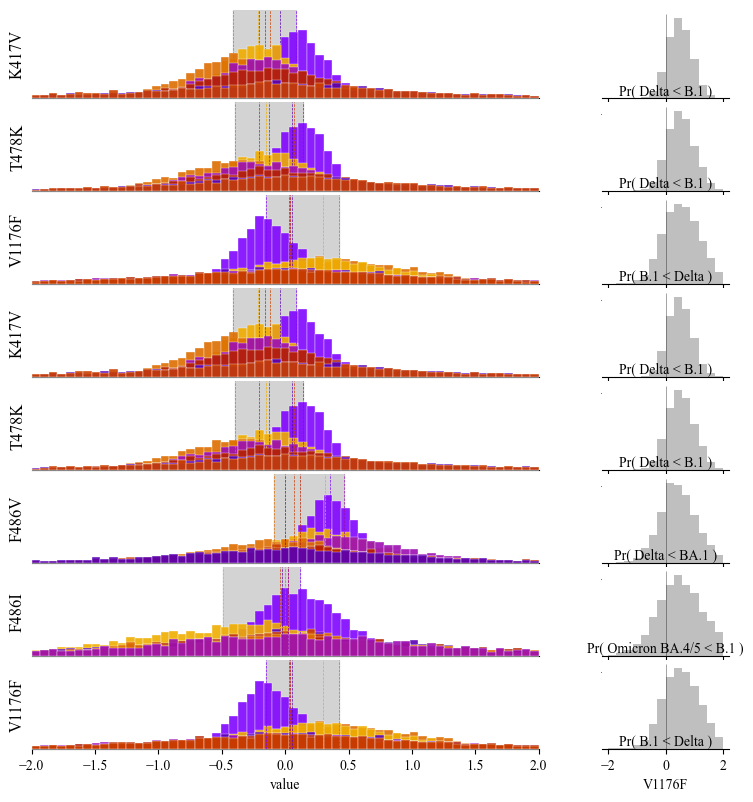

In [69]:
top_n = 8
top_n_muts = mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False).head(top_n)['Mutation'].tolist()
top_n_muts_idxs = [escape_data['features'].index(m) for m in top_n_muts]
top_n_muts_traces = escape_traces['β_ω'][:, :, np.array(top_n_muts_idxs)]

fig, axes = plt.subplots(top_n, 2, figsize=(9, 1.2*top_n), gridspec_kw={'width_ratios':[4,1]})
fig.subplots_adjust(hspace=0.05);
fs = 12

varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

xlim = [-2, 2]
bins = np.linspace(xlim[0], xlim[1], 60)
bins2 = np.linspace(xlim[0], xlim[1], 15)
for i in range(top_n):
    ax = axes[i, 0]
    df_temp = pd.DataFrame(columns=escape_data['pools_map'], data=top_n_muts_traces[:, :, i]).melt(value_vars=escape_data['pools_map'], var_name=['Pool'])
    
    peak_heights = (df_temp
                    .groupby('Pool')['value']
                    .apply(lambda x: np.histogram(x, bins=bins)[0].max())
                    )
    hue_order = peak_heights.sort_values(ascending=False).index.tolist()
    
    # Now, annotate effect range
    effect_min = df_temp.groupby('Pool').agg('mean').min().value
    effect_max = df_temp.groupby('Pool').agg('mean').max().value
    ylim = [0, peak_heights.max()*1.3]
    ax.fill_between([effect_min, effect_max], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='lightgray', zorder=-1)
    for z, pool in enumerate(hue_order):
        sns.histplot(x='value',
            hue='Pool',
            bins=bins,
            linewidth=0.25,
            edgecolor='white',
            alpha=0.9,
            palette=pool_colors,
            data=df_temp[(df_temp['value'].apply(lambda x: x>xlim[0] and x<xlim[1])) & (df_temp['Pool']==pool)],
            zorder=z,
            clip_on=False,
            ax=ax);
        ax.vlines(df_temp[df_temp['Pool']==pool]['value'].mean(), ylim[0], ylim[1], color=pool_colors[pool], linestyle='--', linewidth=0.5, zorder=i)
    ax.set_ylim(ylim);
    
    ax.legend().set_visible(False);
    ax.set_xlim(xlim);
    # ax.set_ylim([0, 0.27]);
    ax.set_yticks([]); ax.set_ylabel(top_n_muts[i], fontsize=fs);
    ax.spines[['left', 'right', 'top']].set_visible(False);
    if i<top_n-1:
        ax.set_xticks([]);
        
        
    # Now, show the effect difference random variable
    ax = axes[i, 1]
    # df_diff_plot = mutation_effect_differences_rv[mutation_effect_differences_rv['Mutation']==top_n_muts[i]].explode('Range (RV) trace')
    df_diff_plot = mutation_effect_differences_rv[mutation_effect_differences_rv['Mutation']==top_n_muts[i]].reset_index(drop=True)
    df_diff_plot = df_diff_plot.head(1).explode('Range (RV) trace')
    sns.histplot(data=df_diff_plot,
                 x='Range (RV) trace',
                 color='gray',
                 alpha=0.5,
                 edgecolor=None,
                 bins=bins2,
                 ax=ax);
    
    ylim = ax.get_ylim();
    ax.vlines(0, ylim[0], ylim[1], linestyle='-', color='k', linewidth=0.5, alpha=0.5);
    ax.set_yticks([]);
    ax.set_ylabel('');
    ax.spines[['top', 'left', 'right']].set_visible(False);
    
    min_varn = df_temp.groupby('Pool').agg('mean').idxmin().item()
    max_varn = df_temp.groupby('Pool').agg('mean').idxmax().item()
    ax.text(0, 0, f'Pr( {min_varn} < {max_varn} )', ha='center', va='bottom');
    ax.set_xlabel(top_n_muts[i]);

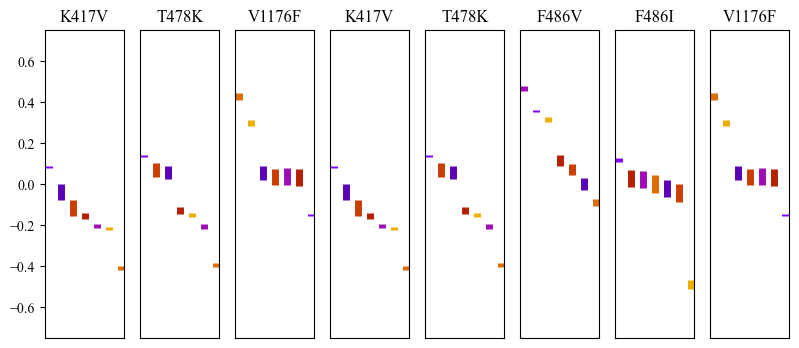

In [129]:
def calc_ci(grp):
    values = grp.values
    m = np.mean(values)
    s = np.std(values)
    ci = [m - 1.645*s/np.sqrt(len(values)), m + 1.645*s/np.sqrt(len(values))]
    return ci
    newgrp = pd.DataFrame({'CI low':ci[0],
                           'CI high':ci[1]})
    return newgrp

top_n = 8
top_n_muts = mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False).head(top_n)['Mutation'].tolist()
top_n_muts_idxs = [escape_data['features'].index(m) for m in top_n_muts]
top_n_muts_traces = escape_traces['β_ω'][:, :, np.array(top_n_muts_idxs)]

fig, axes = plt.subplots(1, top_n, figsize=(1.2*top_n, 4))
fig.subplots_adjust(hspace=0.05);
fs = 12

varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

xlim = [-2, 2]
bins = np.linspace(xlim[0], xlim[1], 60)
bins2 = np.linspace(xlim[0], xlim[1], 15)
for i in range(top_n):
    ax = axes[i]
    df_temp = pd.DataFrame(columns=escape_data['pools_map'], data=top_n_muts_traces[:, :, i]).melt(value_vars=escape_data['pools_map'], var_name=['Pool'])
    df_temp = df_temp.groupby(['Pool']).agg(calc_ci).reset_index()
    df_temp['CI low'] = df_temp['value'].apply(lambda x: x[0])
    df_temp['CI high'] = df_temp['value'].apply(lambda x: x[1])
    df_temp = df_temp.sort_values(by='CI low', ascending=False).reset_index()
    y = df_temp.index
    ax.vlines(y,
              df_temp['CI low'],
              df_temp['CI high'],
              colors=[pool_colors[row['Pool']] for _, row in df_temp.iterrows()],
              linewidth=5
             )
    ax.set_title(top_n_muts[i]);
    ax.set_ylim([-0.75, 0.75]);
    ax.set_xticks([]);
    if i>0:
        ax.set_yticks([]);

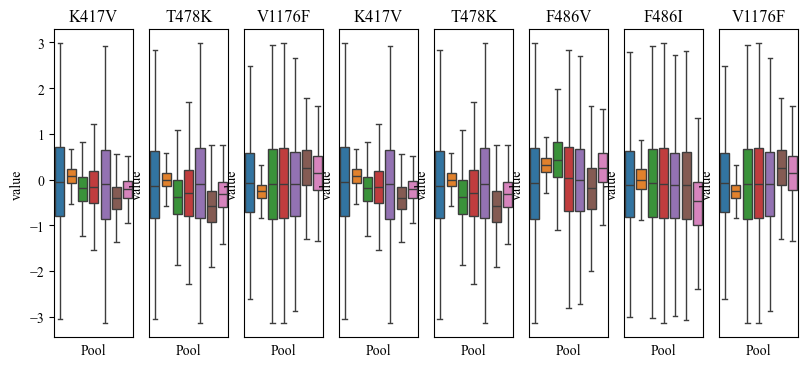

In [135]:
def calc_ci(grp):
    values = grp.values
    m = np.mean(values)
    s = np.std(values)
    ci = [m - 1.645*s/np.sqrt(len(values)), m + 1.645*s/np.sqrt(len(values))]
    return ci
    newgrp = pd.DataFrame({'CI low':ci[0],
                           'CI high':ci[1]})
    return newgrp

top_n = 8
top_n_muts = mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False).head(top_n)['Mutation'].tolist()
top_n_muts_idxs = [escape_data['features'].index(m) for m in top_n_muts]
top_n_muts_traces = escape_traces['β_ω'][:, :, np.array(top_n_muts_idxs)]

fig, axes = plt.subplots(1, top_n, figsize=(1.2*top_n, 4))
fig.subplots_adjust(hspace=0.05);
fs = 12

varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

xlim = [-2, 2]
bins = np.linspace(xlim[0], xlim[1], 60)
bins2 = np.linspace(xlim[0], xlim[1], 15)
for i in range(top_n):
    ax = axes[i]
    df_temp = pd.DataFrame(columns=escape_data['pools_map'], data=top_n_muts_traces[:, :, i]).melt(value_vars=escape_data['pools_map'], var_name=['Pool'])
    # df_temp = df_temp.groupby(['Pool']).agg(calc_ci).reset_index()
    # df_temp['CI low'] = df_temp['value'].apply(lambda x: x[0])
    # df_temp['CI high'] = df_temp['value'].apply(lambda x: x[1])
    # df_temp = df_temp.sort_values(by='CI low', ascending=False).reset_index()
    # y = df_temp.index
    sns.boxplot(
        x='Pool',
        y='value',
        data=df_temp,
        hue='Pool',
        showfliers=False,
        dodge=False,
        ax=ax);
    # ax.vlines(y,
    #           df_temp['CI low'],
    #           df_temp['CI high'],
    #           colors=[pool_colors[row['Pool']] for _, row in df_temp.iterrows()],
    #           linewidth=5
    #          )
    ax.set_title(top_n_muts[i]);
    # ax.set_ylim([-0.75, 0.75]);
    ax.set_xticks([]);
    if i>0:
        ax.set_yticks([]);

<Axes: xlabel='Range (RV) trace', ylabel='Count'>

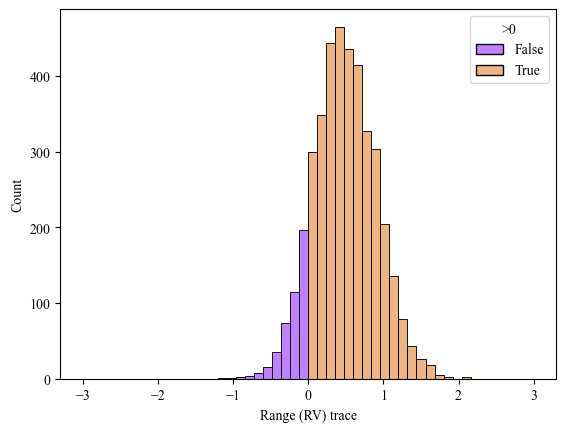

In [86]:
mut = 'K417V'
plot_df = \
mutation_effect_differences_rv[(mutation_effect_differences_rv['Mutation']==mut) &
                               (mutation_effect_differences_rv['Pool 1']=='B.1') & 
                               (mutation_effect_differences_rv['Pool 2']=='Delta')
                              ].explode('Range (RV) trace')
plot_df['>0'] = plot_df['Range (RV) trace']>0
fig, ax = plt.subplots()
bins = np.linspace(-3, 3, 51);
sns.histplot(x='Range (RV) trace',
             hue='>0',
             data=plot_df,
             bins=bins,
             palette={True:pool_colors['Delta'], False:pool_colors['B.1']},
             ax=ax)

In [55]:
# I'd like to recreate this plot, but split the distributions on the right into two halves - color each half by the leading varn
# Rather than annotating as Pr (v1 < v2), could just put v1 at x=-1 and v2 at x=1

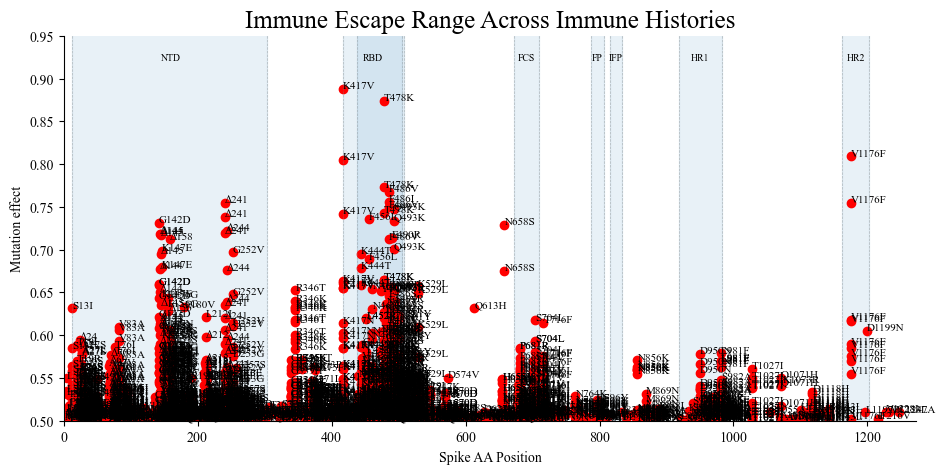

In [56]:
def plot_coef(ax, effects, positions, mutations, options):
    ax.plot(positions, effects, 'ro')
    
    texts = []
    for i, (pos, fea) in enumerate(zip(positions, mutations)):
        x = pos
        y = effects[i]
        text = fea #+ '\n' + '{:1.2f}'.format(y)
        texts.append(ax.annotate(text, xy=(x, y), xytext=(x, y), fontsize=8))
        
        # if i>50:
        #     break
    
    ax.set_xlim(options['xlim'])

fig, ax = plt.subplots(figsize=(11, 5))
options = setup(ax, [0.5, 0.95])
options['ylim'] = [0.5, 0.98]  # move region annotations up a bit
positions, mutations = get_positions(mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False)['Mutation'].tolist())
plot_coef(ax, mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False)['Pr(Range > 0)'].tolist(), positions, mutations, options)
plot_regions(ax, options)
ax.set_title('Immune Escape Range Across Immune Histories', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);

In [139]:
pool_specific_effects

Pool Mutation    Effect  Position Region     Angle  \
0                B.1   A1070S  0.009826      1070  Other  0.897598   
1     Omicron BA.4/5   A1070S  0.009866      1070  Other  5.385587   
2                B.1   A1078T  0.001946      1078  Other  0.897598   
3     Omicron BA.4/5   A1078T -0.041628      1078  Other  5.385587   
4                B.1   A1078V -0.110841      1078  Other  0.897598   
...              ...      ...       ...       ...    ...       ...   
1963  Omicron BA.4/5      Δ76  0.016115        76    NTD  5.385587   
1964             B.1      Δ77  0.023778        77    NTD  0.897598   
1965  Omicron BA.4/5      Δ77  0.002509        77    NTD  5.385587   
1966             B.1      Δ78 -0.005039        78    NTD  0.897598   
1967  Omicron BA.4/5      Δ78 -0.032390        78    NTD  5.385587   

                                                  trace  
0     [tensor(0.0469), tensor(0.2945), tensor(-1.733...  
1     [tensor(1.1133), tensor(0.7097), tensor(-0.137...  
2     [tensor(0.5978), tensor(-1.3525), tensor(1.408...  
3     [tensor(0.0968), tensor(0.6547), tensor(-0.865...  
4     [tensor(-1.0856), tensor(-1.4524), tensor(0.52...  
...                                                 ...  
1963  [tensor(-0.0309), tensor(-0.1035), tensor(0.51...  
1964  [tensor(0.5459), tensor(0.6160), tensor(0.3715...  
1965  [tensor(-0.8879), tensor(0.2410), tensor(0.094...  
1966  [tensor(-0.8287), tensor(0.9247), tensor(-0.66...  
1967  [tensor(2.1832), tensor(2.2072), tensor(-1.531...  

[1968 rows x 7 columns]

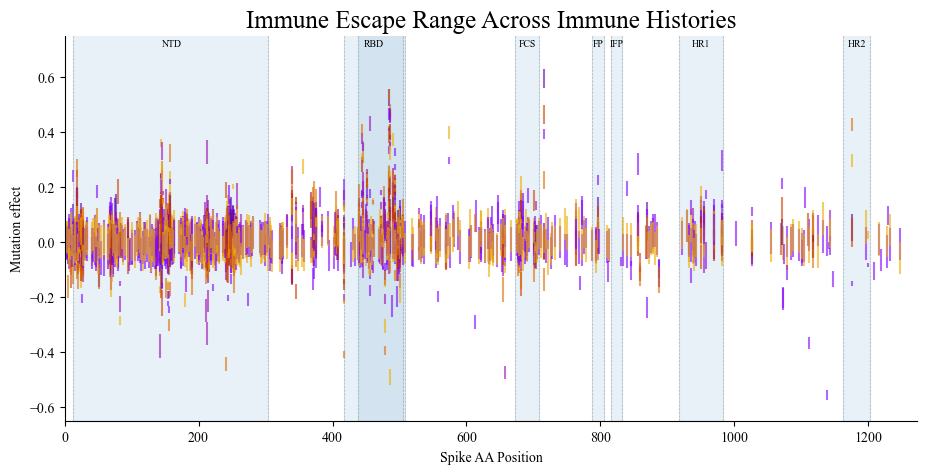

In [146]:
fig, ax = plt.subplots(figsize=(11, 5))
options = setup(ax, [-0.65, 0.75])
options['ylim'] = [-0.65, 0.78]  # move region annotations up a bit
positions, mutations = get_positions(mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False)['Mutation'].tolist())
# plot_coef(ax, mutation_effect_differences_rv.sort_values(by='Pr(Range > 0)', ascending=False)['Pr(Range > 0)'].tolist(), positions, mutations, options)

for _, row in pool_specific_effects.iterrows():
    pool = row['Pool']
    mut = row['Mutation']
    pos = row['Position']
    mutidx = escape_data['features'].index(mut)
    poolidx = escape_data['pools_map'].tolist().index(pool)
    trace = escape_traces['β_ω'][:, poolidx, mutidx].sort().values
    # ci_90 = trace[ci_idxs]
    m = trace.mean()
    s = trace.std()
    ci_90 = [m - 1.645*(s/np.sqrt(tracelen)), m + 1.645*(s/np.sqrt(tracelen))]
    if ~(ci_90[0]<0 and ci_90[1]>0):
        ax.vlines(pos,#+2*np.random.random(),
                  ci_90[0].item(), ci_90[1].item(),
                  color=pool_colors[pool],
                  alpha=0.6,
                  linewidth=1.5)
plot_regions(ax, options)
ax.set_title('Immune Escape Range Across Immune Histories', fontsize=18);
ax.spines[['top', 'right']].set_visible(False);

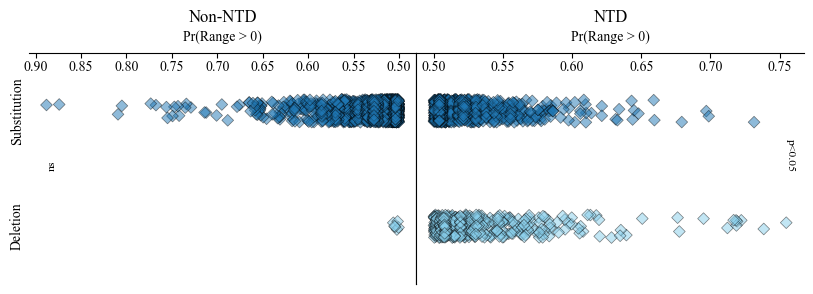

In [88]:
ntd_mutation_effect_differences = mutation_effect_differences_rv[mutation_effect_differences_rv['Pr(Range > 0)']>0.5].copy()
ntd_mutation_effect_differences['Position'] = get_positions(ntd_mutation_effect_differences['Mutation'].tolist())[0]
ntd_mutation_effect_differences['Deletion'] = ntd_mutation_effect_differences['Mutation'].apply(lambda x: 'Deletion' if (x.startswith('Δ') or 'del' in x) else 'Substitution')
ntd_mutation_effect_differences['Region'] = ntd_mutation_effect_differences['Position'].apply(lambda x: 'NTD' if (x>=13 and x <=304) else 'Non-NTD')

palette={'Substitution':'tab:blue', 'Deletion':'skyblue'}

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0)
fs = 12

for i, (r, ax) in enumerate(zip(['Non-NTD', 'NTD'], axes)):
    ax.set_title(r)
    data = ntd_mutation_effect_differences[ntd_mutation_effect_differences['Region']==r]
    sns.stripplot(y='Deletion',
                  x='Pr(Range > 0)',
                  hue='Deletion',
                  data=data.sort_values(by='Deletion', ascending=False),
                  jitter=True,
                  alpha=0.5,
                  marker='D',
                  palette=palette,
                  s=6,
                  linewidth=0.5,
                  edgecolor='k',
                  ax=ax);
    
    # Significance test
    s1 = data[data['Deletion']=='Deletion']['Pr(Range > 0)'].tolist(); 
    s2 = data[data['Deletion']=='Substitution']['Pr(Range > 0)'].tolist();
    res = ttest_ind(s1, s2)
    if res.pvalue < 0.05:
        ax.text(data['Pr(Range > 0)'].max(), 0.5, 'p<0.05', rotation=270, fontsize=fs*0.7)
    else:
        ax.text(data['Pr(Range > 0)'].max(), 0.5, 'ns', rotation=90, fontsize=fs*0.7)

    
    if i == 0:
        spines = ['left', 'bottom']
        yticks = ax.get_yticks()
        yticklabels = ax.get_yticklabels()
        xlim = reversed(ax.get_xlim())
    else:
        spines = ['right', 'bottom']
        yticks = []
        yticklabels = []
        xlim = ax.get_xlim()
        
    ax.spines[spines].set_visible(False);
    ax.set_yticks(yticks);
    ax.set_yticklabels(yticklabels, rotation=90, va='center', ha='right');
    ax.tick_params(axis='y', length=0);
    ax.set_xlim(xlim);
    ax.set_ylabel('');
    xticks = ax.get_xticks(); xticklabels = ax.get_xticklabels()
    # ax.set_xticks(xticks[1:-1]);
    # ax.set_xticklabels(xticklabels[1:-1]);
    ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, direction='in', pad=-15);
    ax.xaxis.set_label_coords(0.5, 1.1);

## CEPI-Only Data

In [58]:
# cepi_date = '2025-06-20'
# sb = .3

# cepi_results = torch.load(f'model_covdb/cepi_only/results.{cepi_date}.sb{sb}.pt')
# cepi_traces = cepi_results['traces']
# cepi_data = cepi_results['data']

In [59]:
# pool_specific_effects = pd.DataFrame(columns=cepi_data['features'], index=cepi_data['pools_map'], data=cepi_traces['β_ω'].mean(dim=0)
#                                     ).reset_index(
#                                     ).melt(id_vars='index', value_vars=None, var_name='Mutation', value_name='Effect'
#                                     ).rename(columns={'index':'Pool'})
# pool_agnostic_effects = pd.DataFrame({'Mutation':cepi_data['features'], 'Effect':cepi_traces['β'].mean(dim=0)})

# # Subset ranges to where we have ample data on each mutation
# min_n = 1  # mutation must have been seen at least once
# subset = []
# for _, row in pool_specific_effects.iterrows():
#     pool_idx = (cepi_data['pools_map']==row['Pool']).nonzero()[0][0]
#     feat_idx = (np.array(cepi_data['features'])==row['Mutation']).nonzero()[0][0]
#     num_obs = cepi_data['X'][cepi_data['pools']==pool_idx, feat_idx].sum().item()
#     row = dict(row)
#     row['N'] = int(num_obs)
#     if num_obs >= min_n:
#         subset.append(row)
# subset = pd.DataFrame(subset)

# pool_specific_effects = pd.merge(pool_specific_effects, subset[['Mutation', 'Pool']], on=['Mutation', 'Pool'], how='inner')

In [60]:
# # Get the difference in pool-specific effects for each mutation
# mutation_effect_differences = pool_specific_effects[
#                                       ['Mutation', 'Effect']
#                                       ].groupby('Mutation'
#                                       ).agg(lambda x: x.max() - x.min()
#                                       ).reset_index(
#                                       ).rename(columns={'Effect':'Effect difference'})

# pool_effect_differences = pd.merge(pool_specific_effects.rename(columns={'Effect':'β_ω'}), 
#                                    pool_agnostic_effects.rename(columns={'Effect':'β'}),
#                                    on=['Mutation'])
# pool_effect_differences['Effect difference'] = pool_effect_differences['β_ω'] - pool_effect_differences['β']
# sorted_pool_effect_differences_df = pool_effect_differences.sort_values(by='Pool', key=lambda x: x.map({p:i for p, i in zip(sortkey['Pool'], sortkey['index'])}))